In [1]:
import numpy as np
import matplotlib.pyplot as plt
import composite
%matplotlib inline
from numpy import trapz

In [2]:
carbon_query = "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where (Carbon = 'A' or Carbon = 'F' or Carbon = 'N') and phase"

In [3]:
SN_Array = composite.grab(carbon_query, multi_epoch = True, make_corr = True)

ERROR:  1998bu_19990126_0_2_00.dat None
ERROR:  2002bo_20020314_0_2_00.dat None
ERROR:  2002bo_20020403_0_2_00.dat None
ERROR:  2002bo_20020421_0_2_00.dat None
ERROR:  2002bo_20020518_0_2_00.dat None
ERROR:  2002bo_20020615_9394_16509_00.dat None
ERROR:  sn2007jg-20070918-not.dat None
ERROR:  sn1992a-19920116.220-iue.flm None
162 questionable files currently ignored
94 questionable spectra removed 2464 spectra left
81 Peculiar Ias removed 2383 spectra left
2108 spectra with host corrections
2108 valid SNe found
Arrays cleaned


In [4]:
names = []
for i, SN in enumerate(SN_Array):
    print i, SN.name, SN.filename, SN.source, SN.phase, SN.carbon
    names.append(SN.name)

0 1989b sn1989b-19890221.flm bsnip 13.455370726 F
1 1989b sn1989b-19890427-o1i1.flm bsnip 78.2981270419 F
2 1989b sn1989b-19890710-o.flm bsnip 152.119111155 F
3 1990n sn1990n-19900717-oi.flm bsnip 7.33808719397 A
4 1990n sn1990n-19900731-oi.flm bsnip 21.4830649943 A
5 1990n sn1990n-19900829-oi.flm bsnip 50.3450784586 A
6 1990n sn1990n-19900830-ir2.flm bsnip 51.1892126231 A
7 1990n sn1990n-19901217-opt2.flm bsnip 160.395457422 A
8 1991bg sn1991bg-19911213-noz.flm bsnip 0.681687715271 N
9 1991bg sn1991bg-19911214-noz.flm bsnip 1.67830718204 N
10 1991bg sn1991bg-19920101-noz.flm bsnip 19.6174575839 N
11 1991bg sn1991bg-19920109-hires-noz.flm bsnip 27.590413318 N
12 1991bg sn1991bg-19920109-noz.flm bsnip 27.590413318 N
13 1991bg sn1991bg-19920130-noz.flm bsnip 48.5194221202 N
14 1991bg sn1991bg-19920313-noz.flm bsnip 91.8653925883 N
15 1991bg sn1991bg-19920523-uoi.flm bsnip 162.441996747 N
16 1991t sn1991t-19910419.flm bsnip -8.66879898507 F
17 1991t sn1991t-19910505.flm bsnip 7.2390784964

In [5]:
events = set(names)
print len(names), 'spectra of', len(events), 'SNe'

2108 spectra of 140 SNe


2003kf -9.47499870953 A


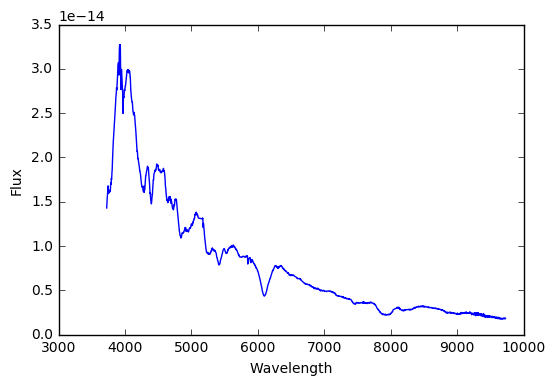

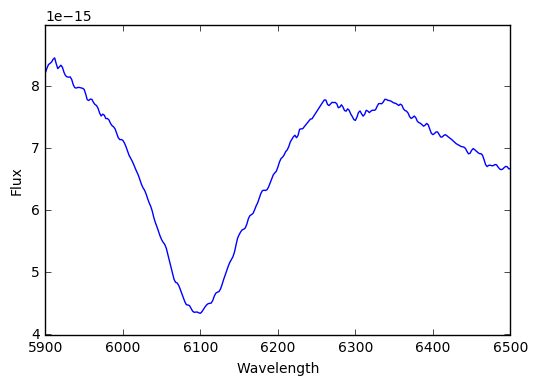

In [6]:
# example = SN_Array[520]
example = SN_Array[1067]
print example.name, example.phase, example.carbon
plt.plot(example.wavelength[example.x1:example.x2], example.flux[example.x1:example.x2])
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()
plt.plot(example.wavelength[example.x1:example.x2], example.flux[example.x1:example.x2])
plt.xlim([5900.,6500.])
plt.ylim([0.4e-14,0.9e-14])
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()

# Defintions

In [7]:
def sm_vexp(sn):
    if sn.SNR >= 40.:
        return 0.001
    elif sn.SNR >= 20. and sn.SNR < 40.:
        return 0.002
    elif sn.SNR < 20.:
        return 0.003

In [8]:
def gsmooth(x_array, y_array, var_y, vexp, nsig = 5.0):
    #returns smoothed flux array
    # if no variance array create a constant one
    if len(var_y) == 0:
        var_y = np.zeros(len(y_array))
        
    for i in range(len(var_y)):
        if var_y[i] == 0:
            var_y[i] = 1E-20
            # var_y[i] = 1E-31
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

In [9]:
def max_wave(sn, w1, w2, error = False, n = 1000):
    wave_domain = (sn.wavelength[sn.x1:sn.x2] > w1) & (sn.wavelength[sn.x1:sn.x2] < w2) #set domain as within minwave and maxwave
    list(wave_domain)
    
    sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], sn.flux[sn.x1:sn.x2], 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))

#     flux_range = sn.flux[wave_domain] #find corresponding flux vales for wavelengths within domain
    elem_flux = max(sm_flux[wave_domain]) #find minimum value within these flux vales to locate "dip"
    max_wave = sn.wavelength[sn.x1:sn.x2][wave_domain][np.where(sm_flux[wave_domain] == elem_flux)][0] #find the corresponding wavelength
        
    local_flux_error = (1./sn.ivar[sn.x1:sn.x2][wave_domain])**0.5
    local_median_error = np.median(local_flux_error)
        
    if error == True:
        flux_dist = []
        for i in range(n):
            point_sample = np.random.normal(elem_flux, local_median_error)
            flux_dist.append(point_sample)
        
        lower68bound = sorted(flux_dist)[int(round(n * .16)) - 1]
        upper68bound = sorted(flux_dist)[int(round(n * .84)) - 1]
        sigma = local_median_error
        return max_wave, sigma, lower68bound, upper68bound
        
    else:
        return max_wave

In [10]:
def eq_width(sn, w1, w2, w3, plot=False):
    
    max_1 = max_wave(sn, w1, w2, False)
    max_2 = max_wave(sn, w2, w3, False)
    
    if max_2-max_1<40.:
        max_1=6280.
        max_2=6350.
    
    domain = (sn.wavelength[sn.x1:sn.x2] >= max_1) & (sn.wavelength[sn.x1:sn.x2] <= max_2)
    list(domain)
    wave_range = sn.wavelength[sn.x1:sn.x2][domain]
    flux_range = sn.flux[sn.x1:sn.x2][domain]
    
    sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], sn.flux[sn.x1:sn.x2], 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))

    line_elem = np.polyfit([max_1, max_2], [sm_flux[np.where(sn.wavelength[sn.x1:sn.x2] == max_1)],
                                            sm_flux[np.where(sn.wavelength[sn.x1:sn.x2] == max_2)]], 1)
#         print(line_elem)
    line = line_elem[0] * wave_range + line_elem[1]
#         print line
#         ask about this

    norm = flux_range / line
    #new_norm = norm * 0 + 0.3
    #print (new_norm)


    a_curve = trapz((norm), x = wave_range)
    a_line = max(wave_range) - min(wave_range)

    eq_width = a_line - a_curve
    
    if plot==True:
        plt.figure()
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))],sn.flux[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))])
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))],sm_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))], color='blue')
#         plt.xlim([6200.,6400.])
#         plt.ylim([20.,30.])
        plt.axvline (x=max_1, color = 'red')
        plt.axvline (x=max_2, color = 'red')
        plt.plot(sn.wavelength[sn.x1:sn.x2][domain],line, color='orange')
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.show()
        
        plt.figure()
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))],sn.flux[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))])
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))],sm_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))], color='blue')
#         plt.xlim([6200.,6400.])
#         plt.ylim([20.,30.])
        plt.axvline (x=max_1, color = 'red')
        plt.axvline (x=max_2, color = 'red')
        plt.plot(sn.wavelength[sn.x1:sn.x2][domain],line, color='orange')
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.show()

#         plt.plot(norm, color = 'black')
#         plt.plot(wave_range, norm, color = "orange")
#         plt.plot(wave_range , 1, color = "yellow")
#         plt.axvline (x=max_1, color = 'red')
#         plt.axvline (x=max_2, color = 'blue')

    return eq_width

In [11]:
unique_events = []
SN_ls = []

for i in range(len(SN_Array)): 
    if SN_Array[i].name not in unique_events:
        unique_events.append(SN_Array[i].name)

for i in range(len(unique_events)):
    events = []
    phases = []
    for SN in SN_Array:
        if SN.name == unique_events[i]:
            events.append(SN)
            phases.append(SN.phase)
    for e in events:
        if e.phase == min(phases):
            SN_ls.append(e)

In [12]:
New_SN_Array=[]
for i in SN_ls:
    if i.phase<7 and i.x2>2700 and i.x1<2550:
        New_SN_Array.append(i)

In [13]:
for i in SN_Array:
    if i in New_SN_Array:
        i.__setattr__('ew_c', eq_width(i, 6200, 6300, 6400))
    else:
        i.__setattr__('ew_c', 'nan')

In [14]:
# for i in New_SN_Array:
#     print i.ew_c

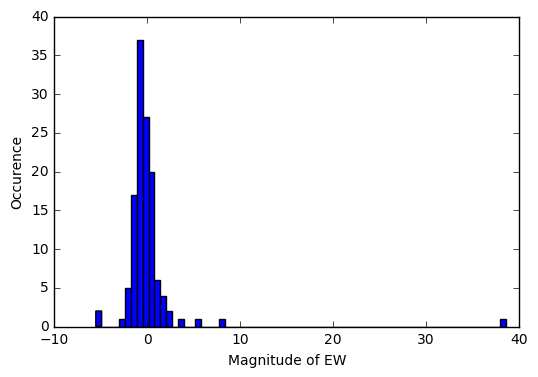

In [15]:
eq_width_ls=[]
for i in New_SN_Array:
    eq_width_ls.append(i.ew_c)
    
plt.hist(eq_width_ls, 70)
plt.xlabel('Magnitude of EW')
plt.ylabel('Occurence')
plt.show()

# Equivalent Width Error

In [16]:
# def max_wave_gaussian(sn, new_flux, w1, w2, error = False, n = 1000):
#     wave_domain = (sn.wavelength[sn.x1:sn.x2] >= w1) & (sn.wavelength[sn.x1:sn.x2] <= w2) #set domain as within minwave and maxwave
#     list(wave_domain)
    
#     sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], new_flux, 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))

# #     flux_range = sn.flux[wave_domain] #find corresponding flux vales for wavelengths within domain
#     elem_flux = max(sm_flux[wave_domain]) #find minimum value within these flux vales to locate "dip"
#     max_wave = sn.wavelength[sn.x1:sn.x2][wave_domain][np.where(sm_flux[wave_domain] == elem_flux)][0] #find the corresponding wavelength
        
#     local_flux_error = (1./sn.ivar[sn.x1:sn.x2][wave_domain])**0.5
#     local_median_error = np.median(local_flux_error)
        
#     if error == True:
#         flux_dist = []
#         for i in range(n):
#             point_sample = np.random.normal(elem_flux, local_median_error)
#             flux_dist.append(point_sample)
        
#         lower68bound = sorted(flux_dist)[int(round(n * .16)) - 1]
#         upper68bound = sorted(flux_dist)[int(round(n * .84)) - 1]
#         sigma = local_median_error
#         return max_wave, sigma, lower68bound, upper68bound
        
#     else:
#         return max_wave

In [17]:
def eq_width_gaussian(sn, new_flux, w1, w2, w3, plot=False):
    max_1 = max_wave(sn, w1, w2, False)
    max_2 = max_wave(sn, w2, w3, False)
    
    if max_2-max_1<40.:
        max_1=6280.
        max_2=6350.

    domain = (sn.wavelength[sn.x1:sn.x2] >= max_1) & (sn.wavelength[sn.x1:sn.x2] <= max_2)
    list(domain)
    wave_range = sn.wavelength[sn.x1:sn.x2][domain]
    flux_range = new_flux[domain]
    
    sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], new_flux, 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))

    line_elem = np.polyfit([max_1, max_2], [sm_flux[np.where(sn.wavelength[sn.x1:sn.x2] == max_1)],
                                            sm_flux[np.where(sn.wavelength[sn.x1:sn.x2] == max_2)]], 1)
#         print(line_elem)
    line = line_elem[0] * wave_range + line_elem[1]
#         print line
#         ask about this

    norm = flux_range / line
    #new_norm = norm * 0 + 0.3
    #print (new_norm)


    a_curve = trapz((norm), x = wave_range)
    a_line = max(wave_range) - min(wave_range)

    eq_width = a_line - a_curve
    
    if plot==True:
        plt.figure()
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))], new_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))])
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))], sm_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6000.) & (sn.wavelength[sn.x1:sn.x2]<6500.))], color='blue')
        plt.axvline (x=max_1, color = 'red')
        plt.axvline (x=max_2, color = 'red')
        plt.plot(sn.wavelength[sn.x1:sn.x2][domain],line, color='orange')
#         plt.xlim([6200.,6400.])
        plt.show()

        plt.figure()
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))], new_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))])
        plt.plot(sn.wavelength[sn.x1:sn.x2][np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))], sm_flux[np.where((sn.wavelength[sn.x1:sn.x2]>6200.) & (sn.wavelength[sn.x1:sn.x2]<6400.))], color='blue')
        plt.axvline (x=max_1, color = 'red')
        plt.axvline (x=max_2, color = 'red')
        plt.plot(sn.wavelength[sn.x1:sn.x2][domain],line, color='orange')
#         plt.xlim([6200.,6400.])
        plt.show()
#         plt.plot(norm, color = 'black')
#         plt.plot(wave_range, norm, color = "orange")
#         plt.plot(wave_range , 1, color = "yellow")
#         plt.axvline (x=max_1, color = 'red')
#         plt.axvline (x=max_2, color = 'blue')

    return eq_width

In [18]:
def ew_error(sn, num, plot=False):
    eq_width_gaussians=[]
    locs=np.where((sn.wavelength[sn.x1:sn.x2] >= 6200) & (sn.wavelength[sn.x1:sn.x2] <= 6400))
    sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], sn.flux[sn.x1:sn.x2], 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))
    sig= np.average(np.absolute(sn.flux[sn.x1:sn.x2][locs] - sm_flux[locs]))
    
    for i in range(0,num):
        sm_flux= gsmooth(sn.wavelength[sn.x1:sn.x2], sn.flux[sn.x1:sn.x2], 1/sn.ivar[sn.x1:sn.x2], sm_vexp(sn))
        new_flux=sm_flux
        delta_flux= np.random.normal(loc=0, scale=sig, size=101)
        new_flux[locs]= new_flux[locs] + delta_flux
        eq_width_gaussians.append(eq_width_gaussian(sn, new_flux, 6200, 6300, 6400))
        
        if plot==True:
            print eq_width_gaussian(sn, new_flux, 6200, 6300, 6400, plot=True)

        np.warnings.filterwarnings('ignore')
    return np.std(eq_width_gaussians)#, np.average(eq_width_gaussians)#, plt.hist(eq_width_gaussians, 60)

In [19]:
# for i in SN_Array:
#     if i in New_SN_Array:
#         i.__setattr__('ew_c_error', ew_error(i,1000))
#     else:
#         i.__setattr__('ew_c_error', 'nan')

0 | 1991bg | N


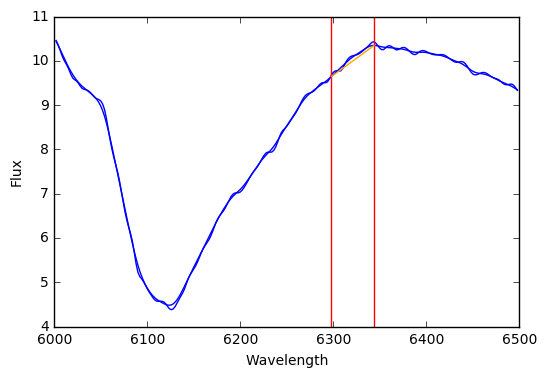

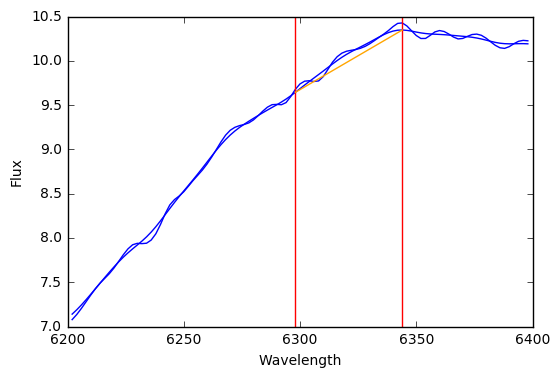

-0.320028638293
-----------------------------------------------------------------------------------------
1 | 1991t | F


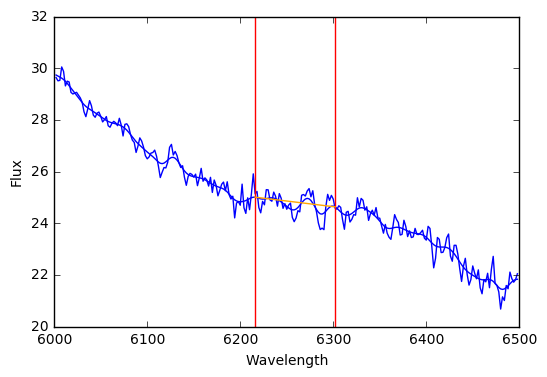

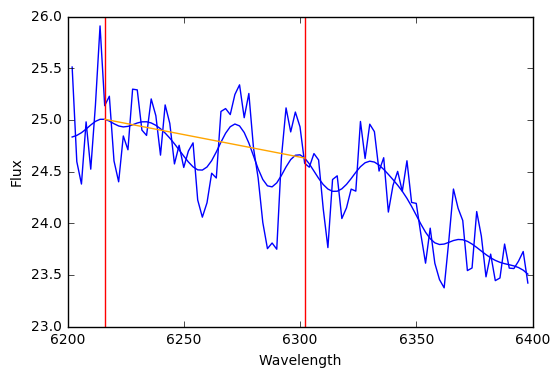

0.258871126148
-----------------------------------------------------------------------------------------
2 | 1994d | A


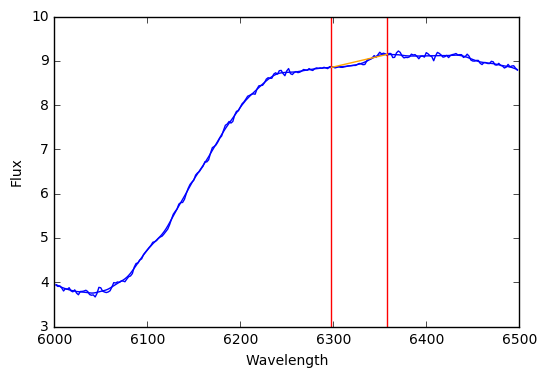

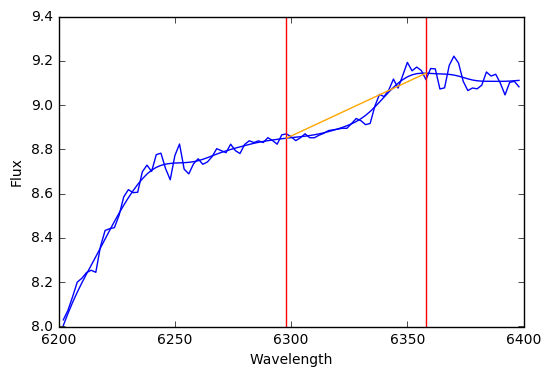

0.189331461031
-----------------------------------------------------------------------------------------
3 | 1994s | N


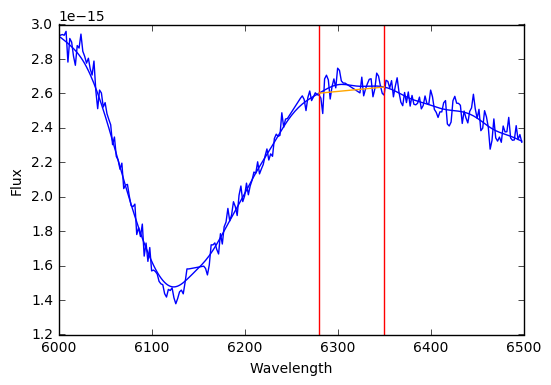

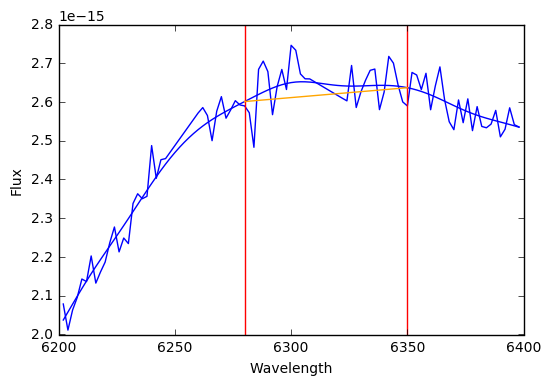

-0.657326148833
-----------------------------------------------------------------------------------------
4 | 1995e | F


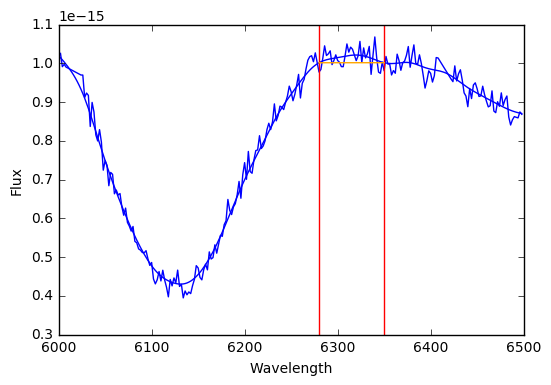

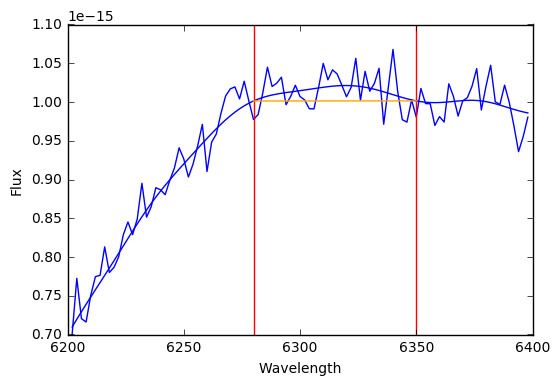

-0.985672754885
-----------------------------------------------------------------------------------------
5 | 1997br | N


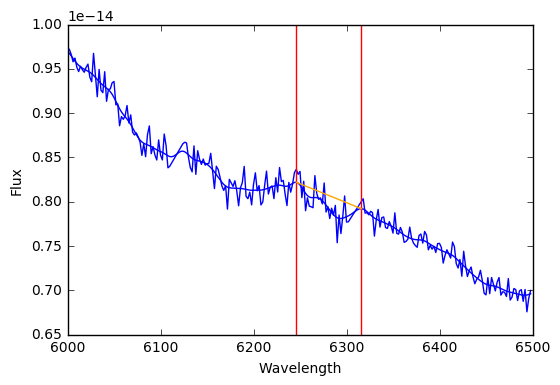

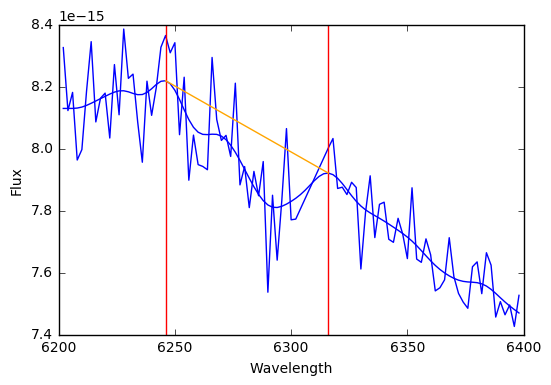

0.937660577792
-----------------------------------------------------------------------------------------
6 | 1997do | N


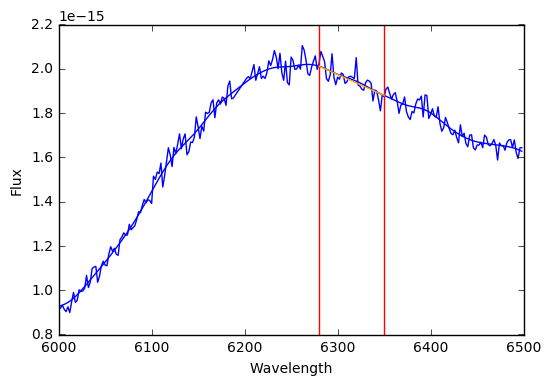

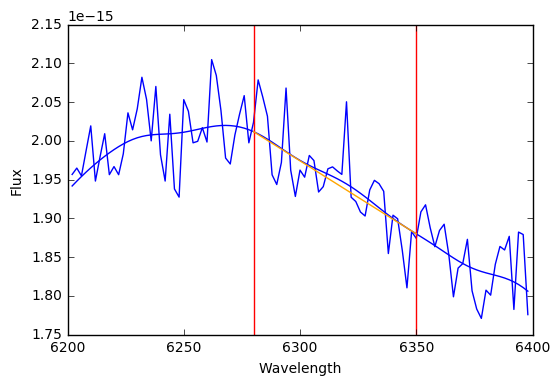

-0.116376348602
-----------------------------------------------------------------------------------------
7 | 1997y | N


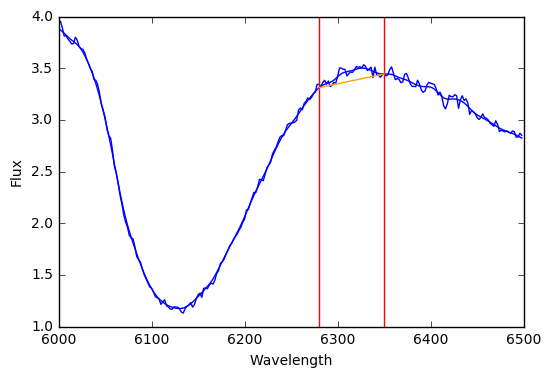

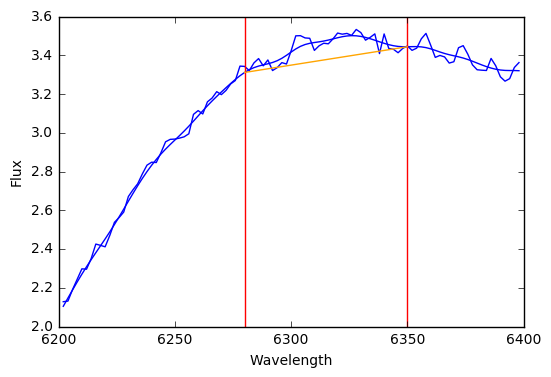

-1.31685410858
-----------------------------------------------------------------------------------------
8 | 1998aq | F


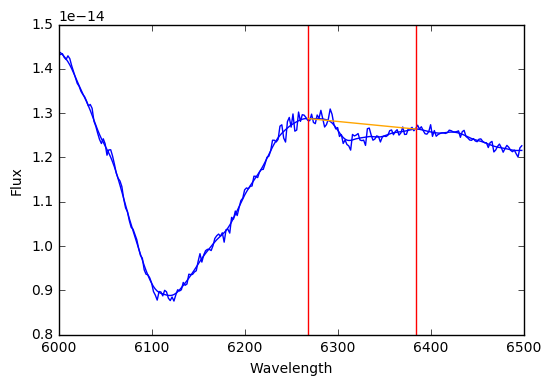

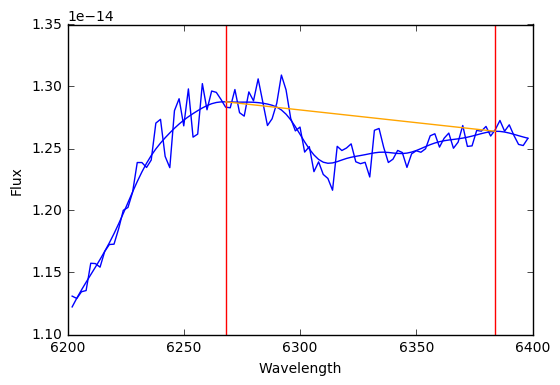

1.51816829883
-----------------------------------------------------------------------------------------
9 | 1998bp | N


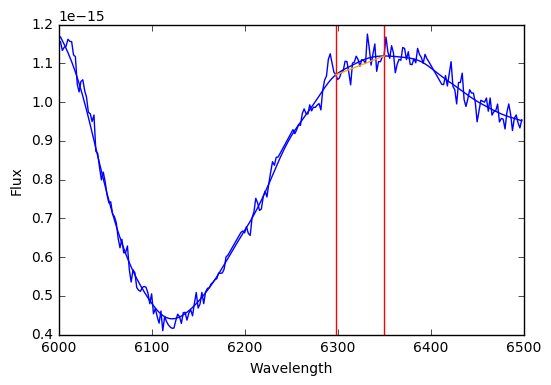

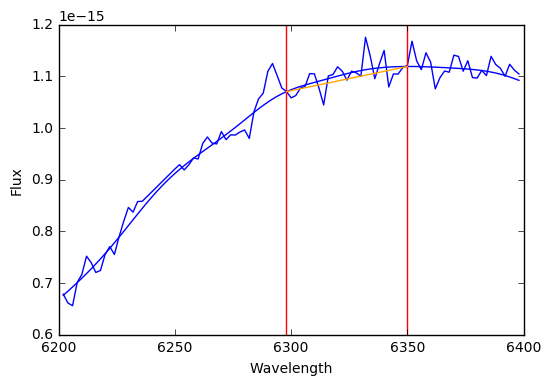

-0.320696286173
-----------------------------------------------------------------------------------------
10 | 1998bu | F


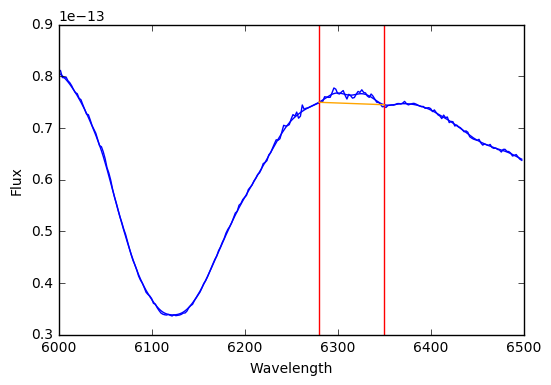

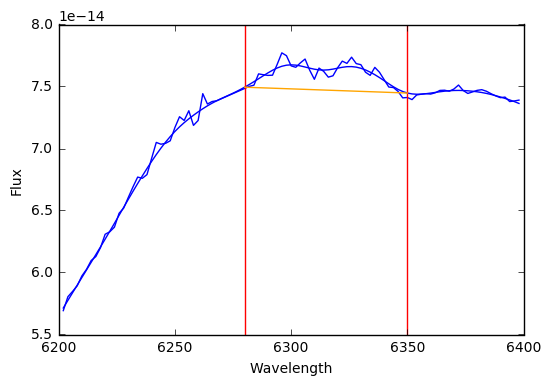

-1.32089929664
-----------------------------------------------------------------------------------------
11 | 1998de | N


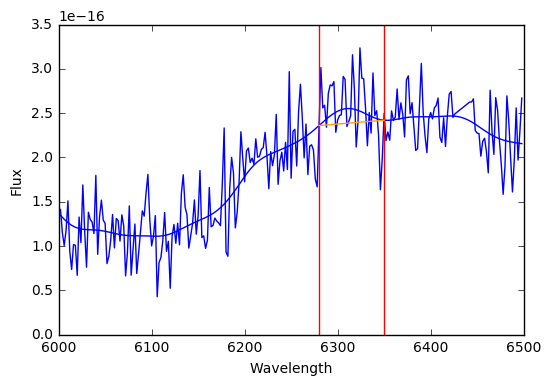

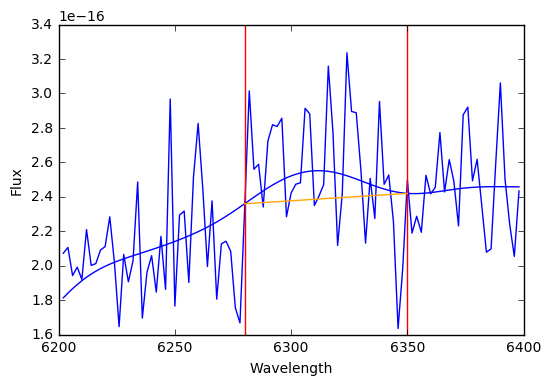

-5.00542812762
-----------------------------------------------------------------------------------------
12 | 1998dh | N


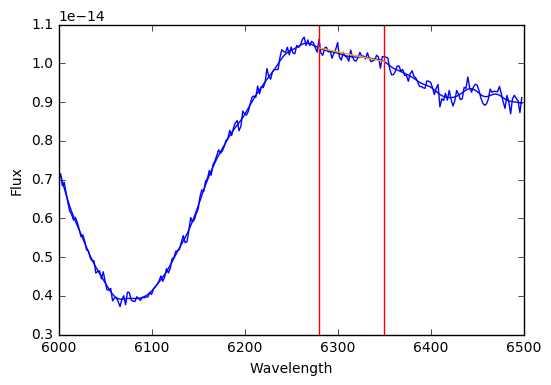

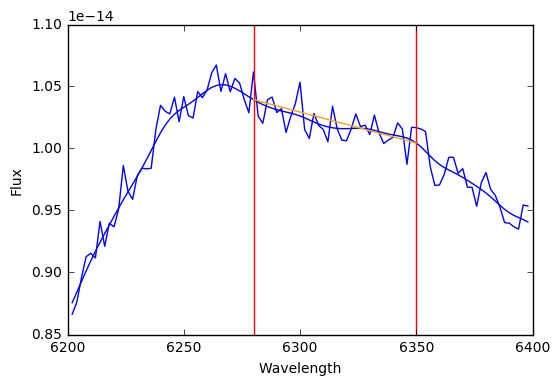

0.127807757003
-----------------------------------------------------------------------------------------
13 | 1998dk | F


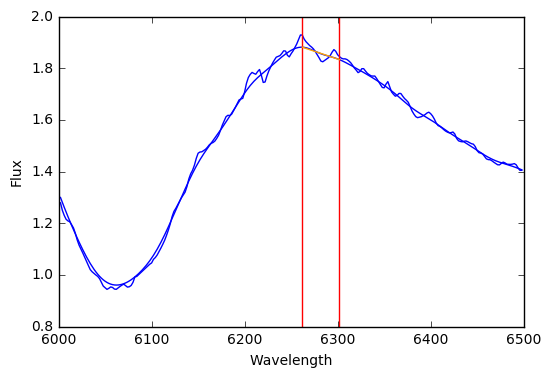

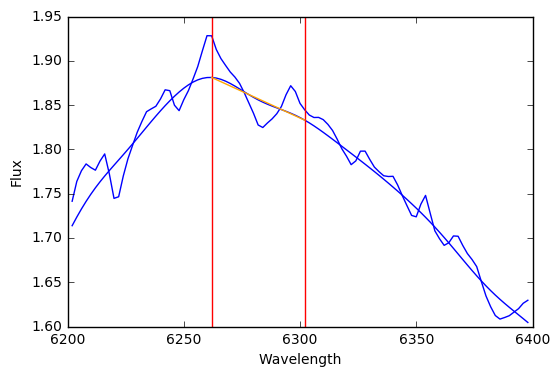

-0.118692373053
-----------------------------------------------------------------------------------------
14 | 1998dm | A


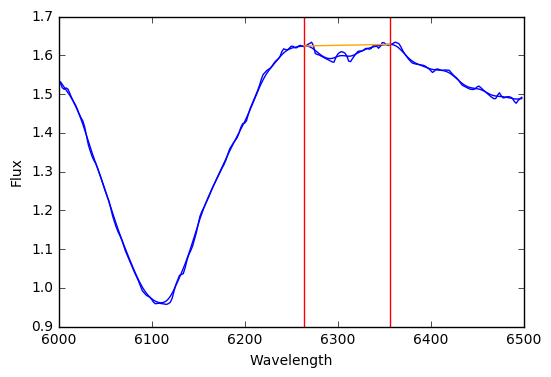

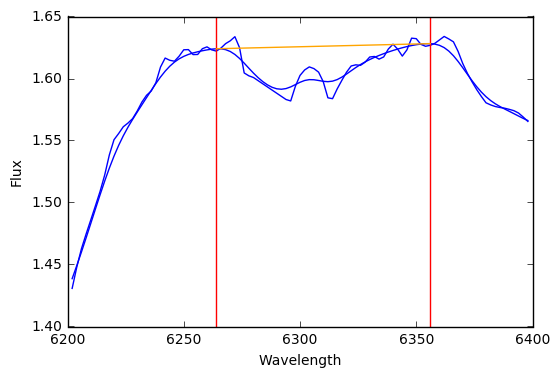

0.95346476439
-----------------------------------------------------------------------------------------
15 | 1998ec | N


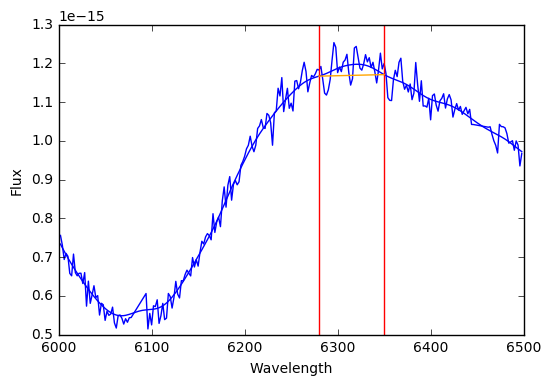

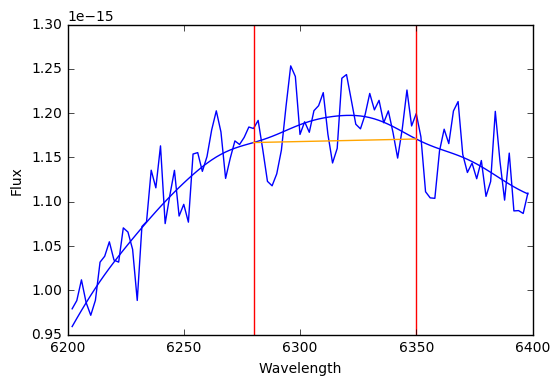

-1.27702572748
-----------------------------------------------------------------------------------------
16 | 1998ef | N


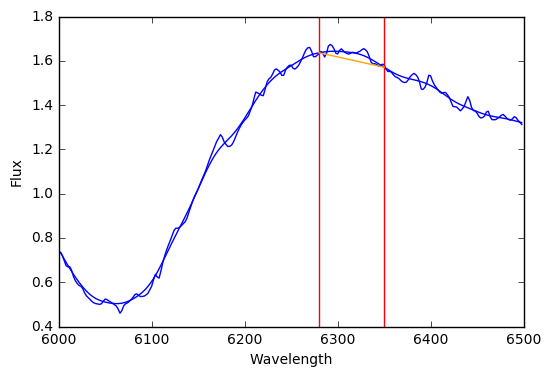

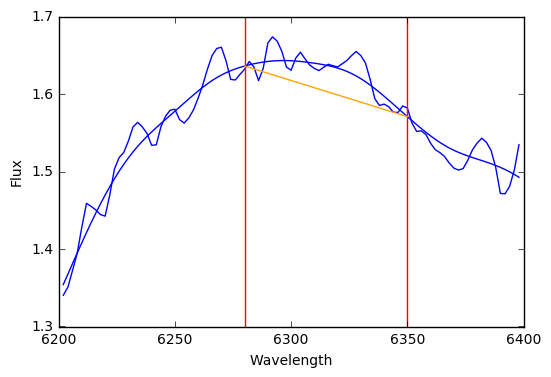

-1.13936453314
-----------------------------------------------------------------------------------------
17 | 1998es | N


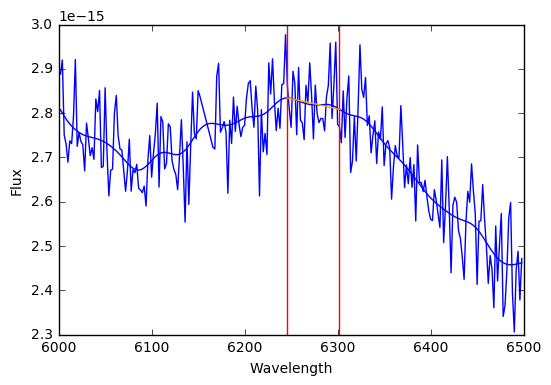

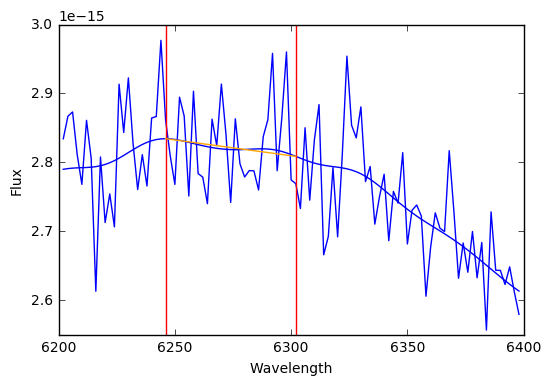

-0.0793092858018
-----------------------------------------------------------------------------------------
18 | 1999aa | N


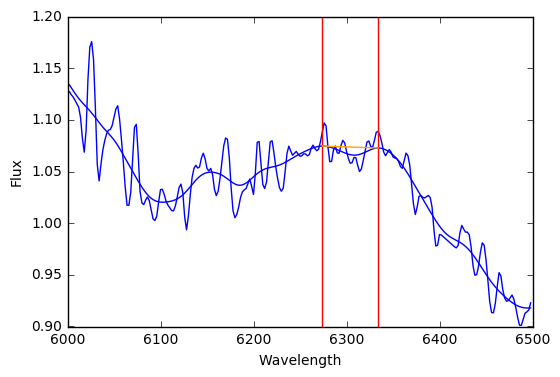

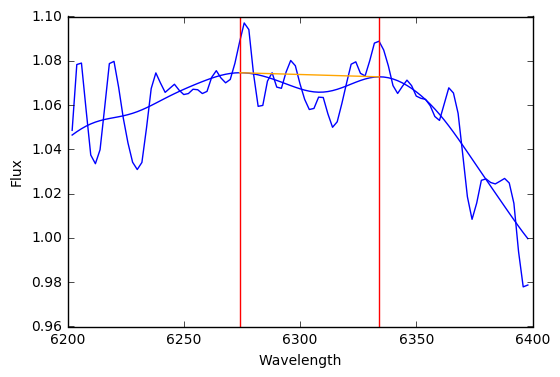

0.159034926141
-----------------------------------------------------------------------------------------
19 | 1999ac | F


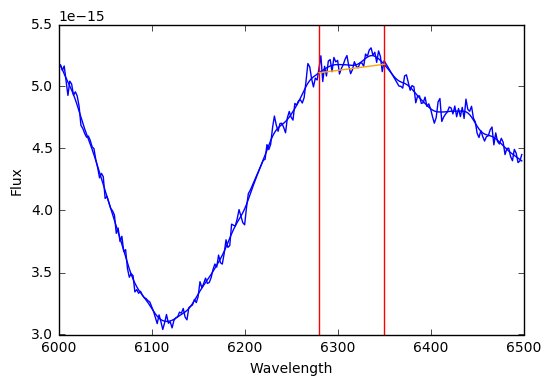

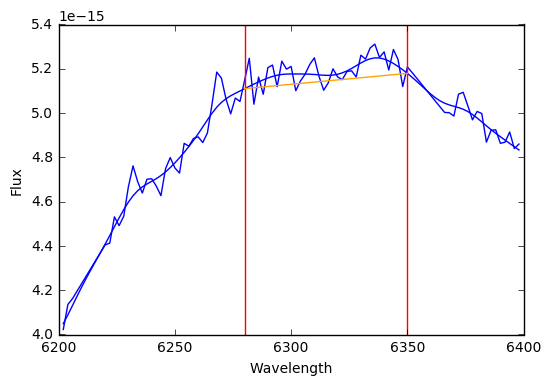

-0.646192284231
-----------------------------------------------------------------------------------------
20 | 1999by | F


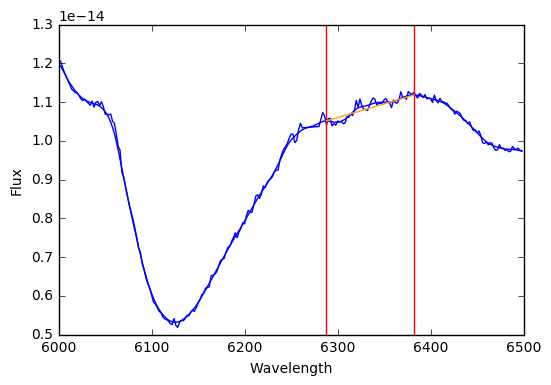

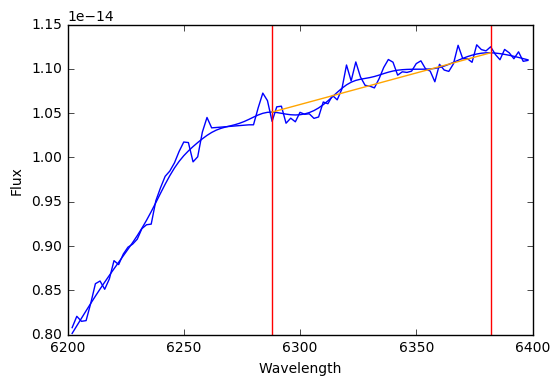

-0.119453922713
-----------------------------------------------------------------------------------------
21 | 1999cl | N


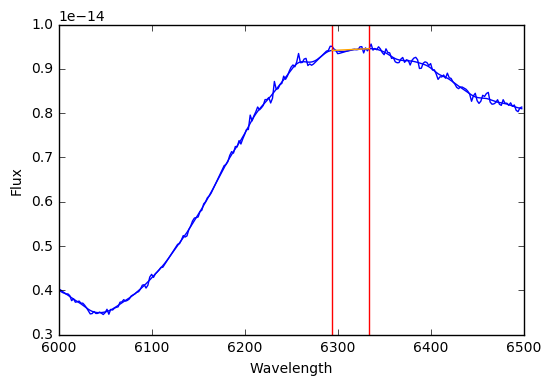

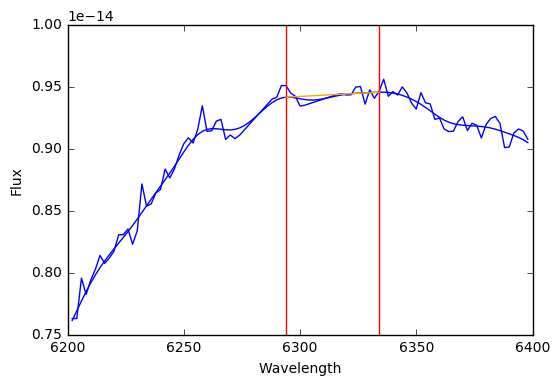

0.0658194114011
-----------------------------------------------------------------------------------------
22 | 1999da | N


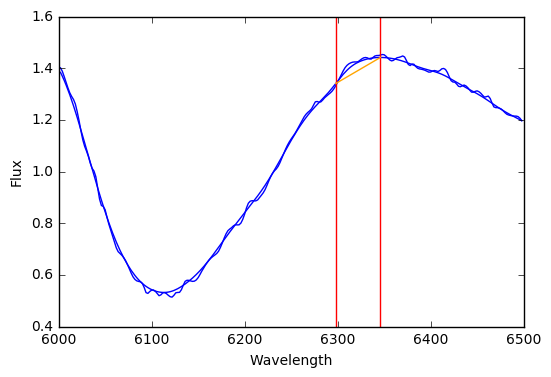

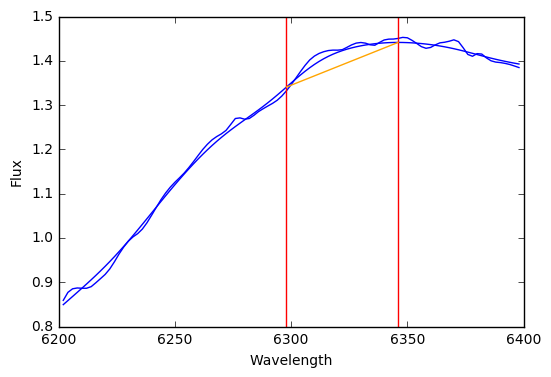

-0.962147978159
-----------------------------------------------------------------------------------------
23 | 1999dk | F


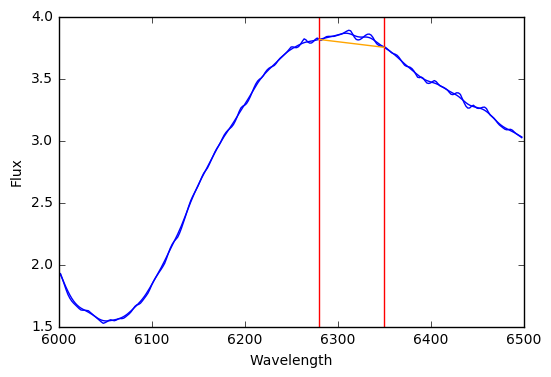

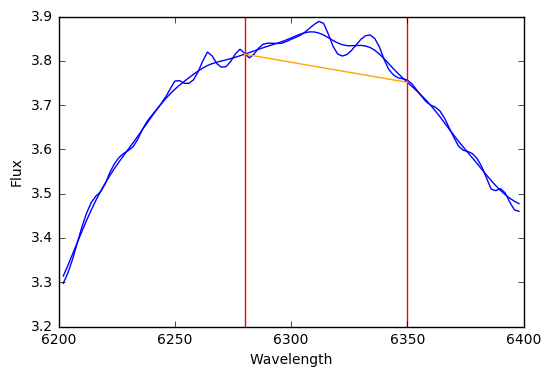

-0.914588976085
-----------------------------------------------------------------------------------------
24 | 1999dq | N


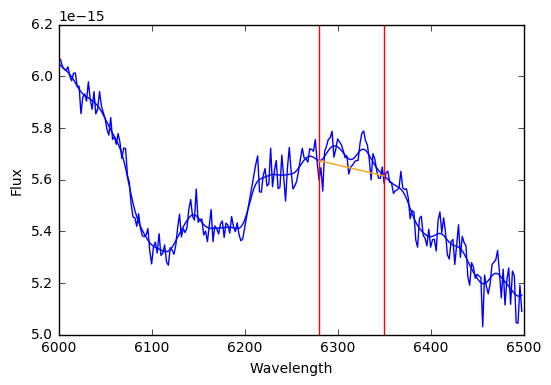

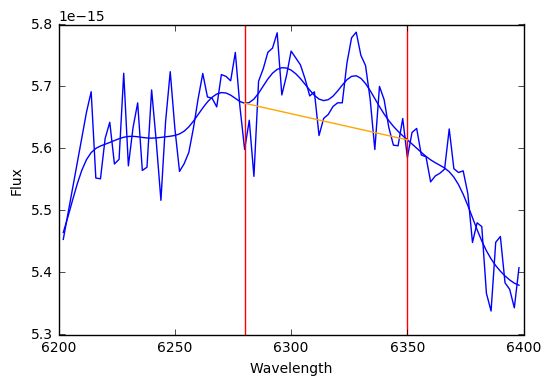

-0.574294407654
-----------------------------------------------------------------------------------------
25 | 1999gd | N


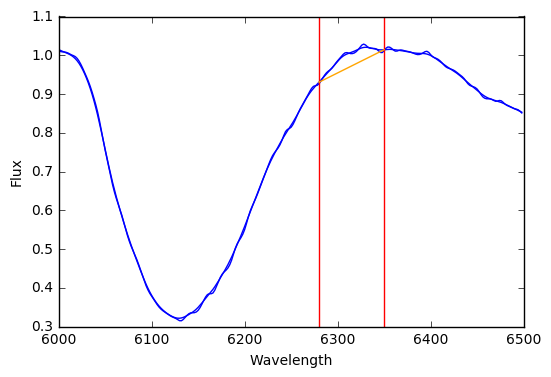

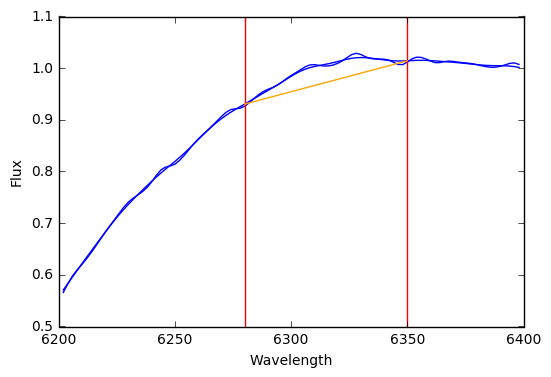

-1.69616254012
-----------------------------------------------------------------------------------------
26 | 2000dk | N


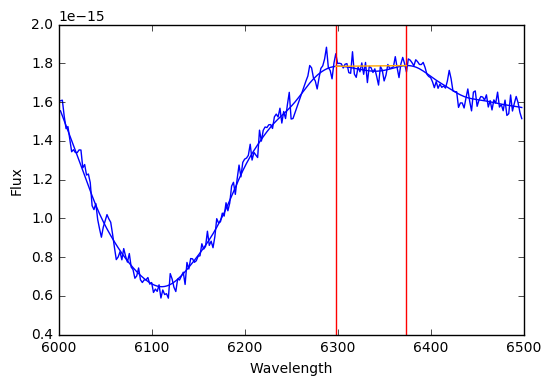

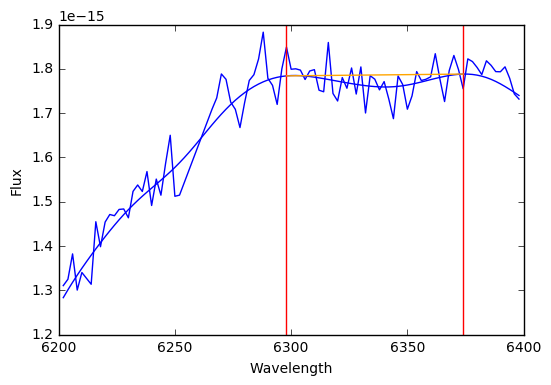

0.561396136202
-----------------------------------------------------------------------------------------
27 | 2001az | F


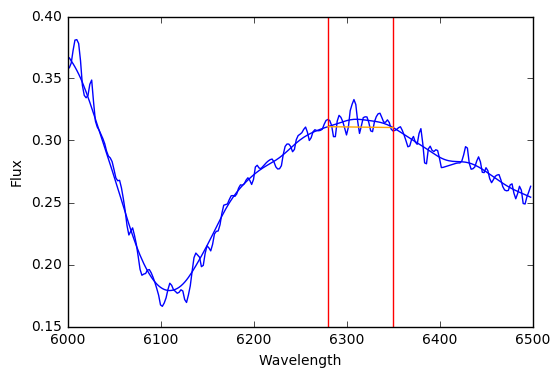

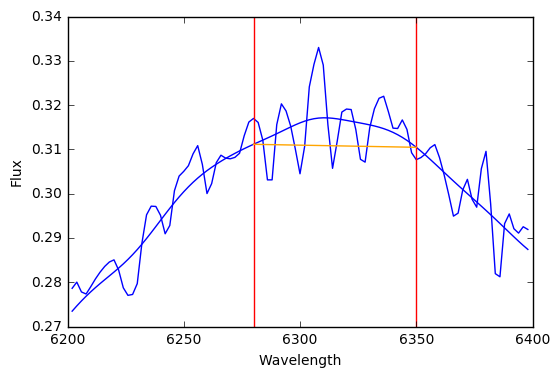

-1.05475784676
-----------------------------------------------------------------------------------------
28 | 2001bf | N


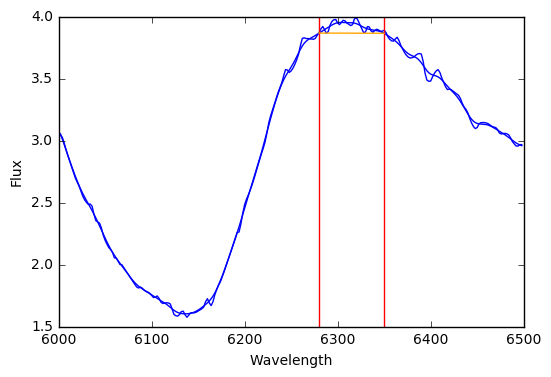

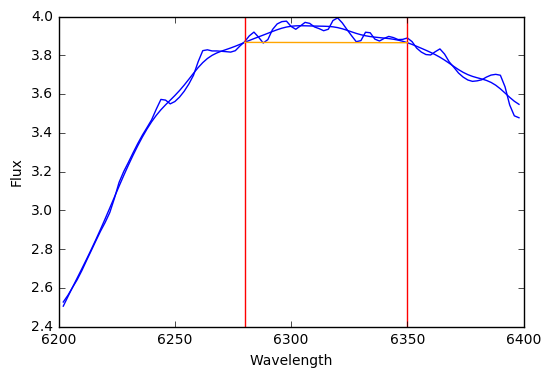

-1.00768859601
-----------------------------------------------------------------------------------------
29 | 2001cp | F


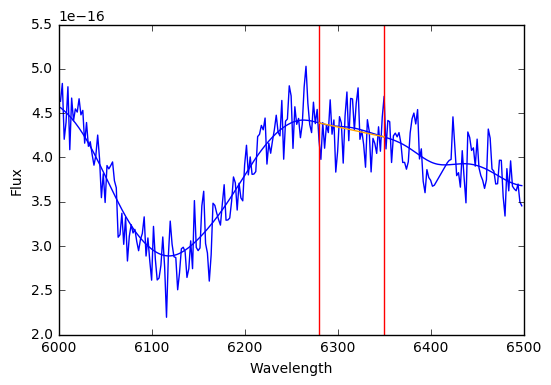

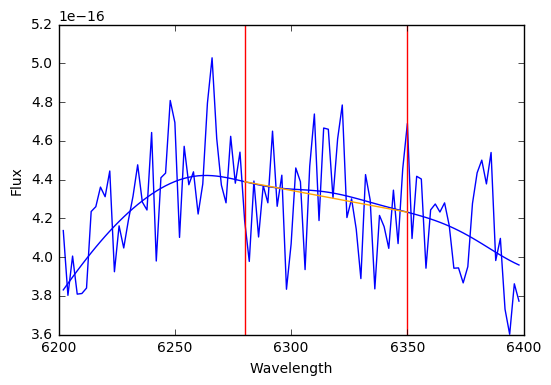

0.214503109492
-----------------------------------------------------------------------------------------
30 | 2001da | N


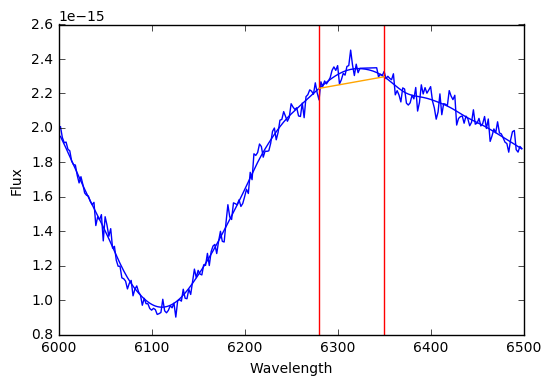

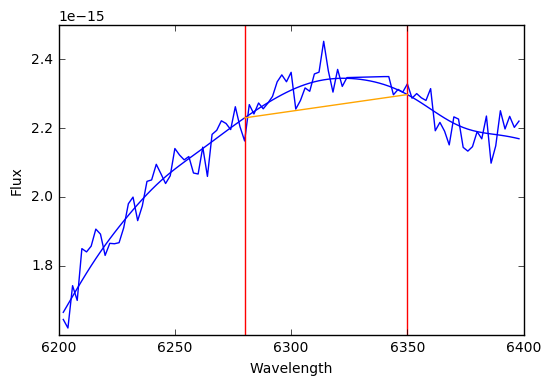

-1.85484752796
-----------------------------------------------------------------------------------------
31 | 2001eh | N


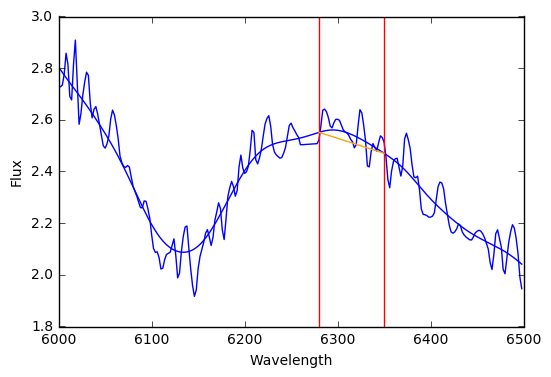

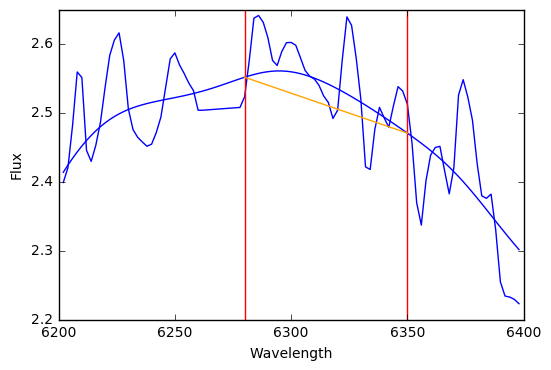

-1.10874047236
-----------------------------------------------------------------------------------------
32 | 2001ep | N


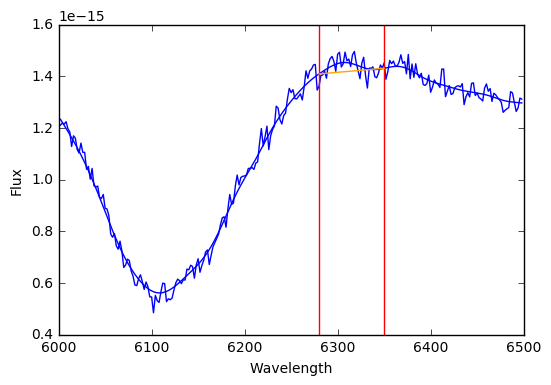

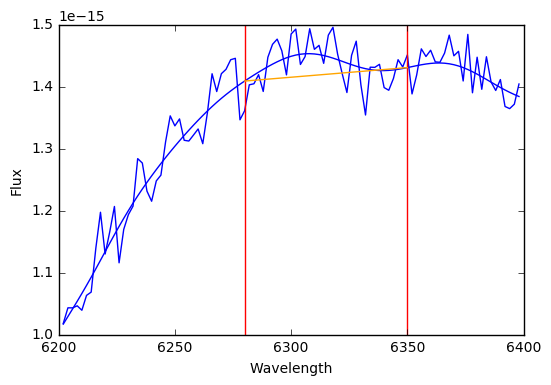

-0.878556054366
-----------------------------------------------------------------------------------------
33 | 2001fe | F


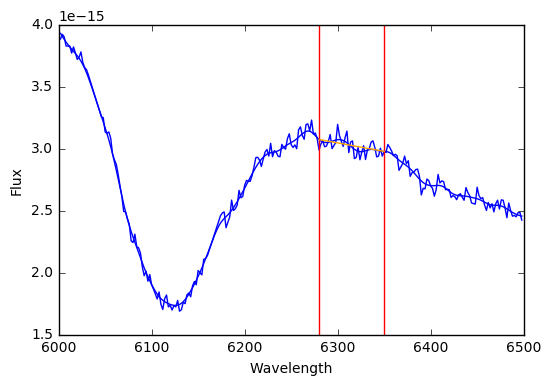

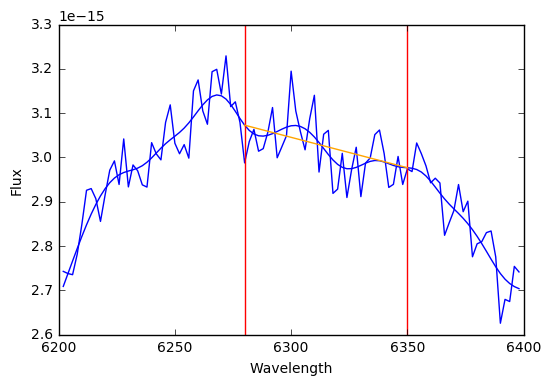

0.155664460706
-----------------------------------------------------------------------------------------
34 | 2001v | F


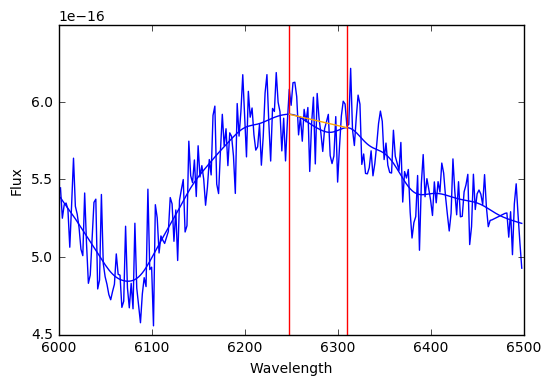

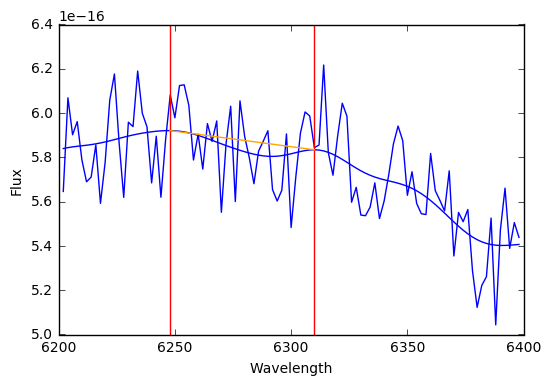

0.254746911103
-----------------------------------------------------------------------------------------
35 | 2002bo | N


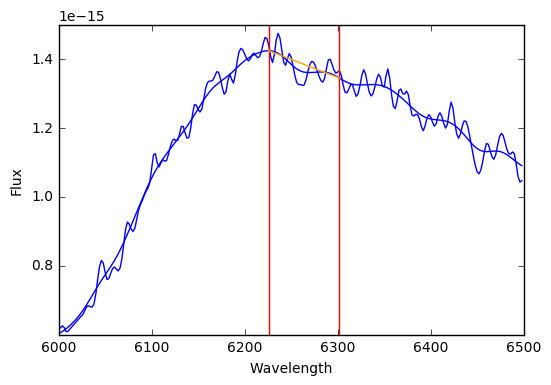

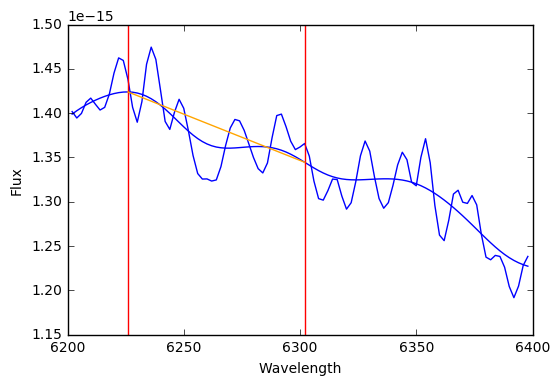

0.277726036256
-----------------------------------------------------------------------------------------
36 | 2002bo | N


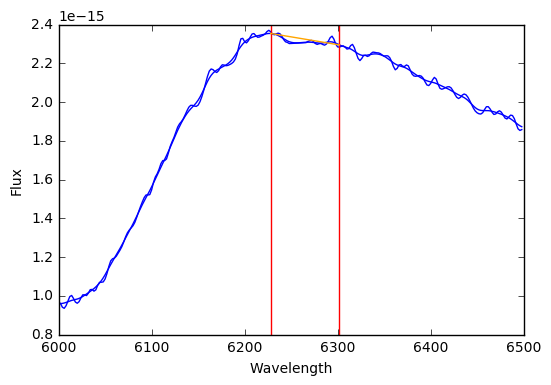

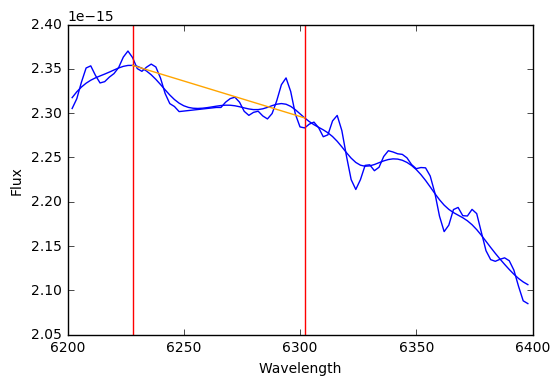

0.299186877738
-----------------------------------------------------------------------------------------
37 | 2002ck | F


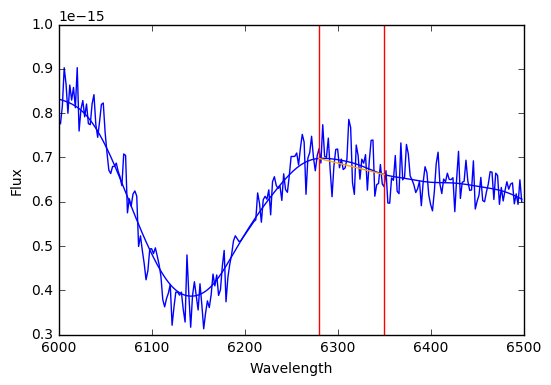

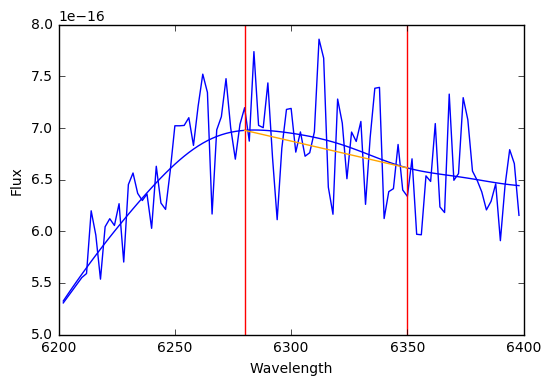

-0.921284799751
-----------------------------------------------------------------------------------------
38 | 2002cr | A


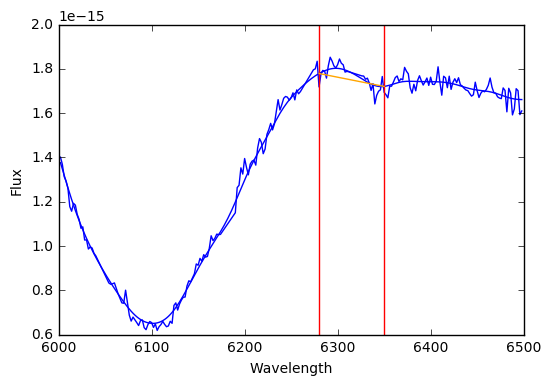

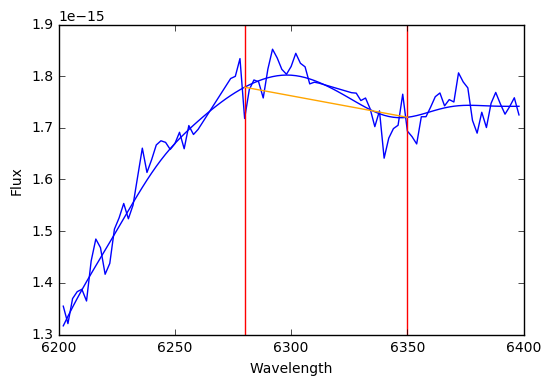

-0.841398914165
-----------------------------------------------------------------------------------------
39 | 2002dj | N


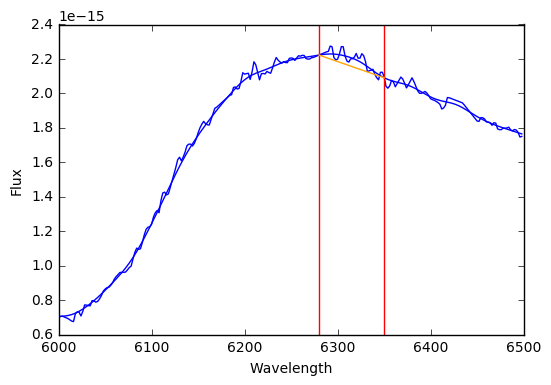

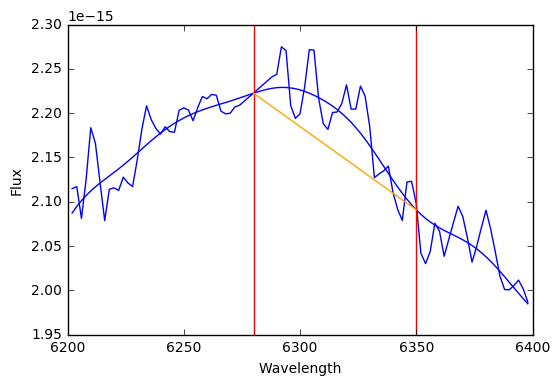

-1.21401233555
-----------------------------------------------------------------------------------------
40 | 2002er | F


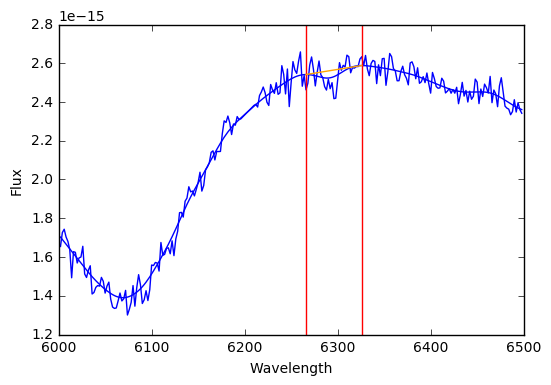

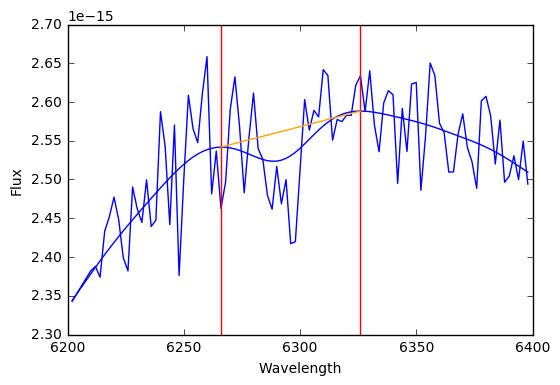

0.410565642767
-----------------------------------------------------------------------------------------
41 | 2002eu | N


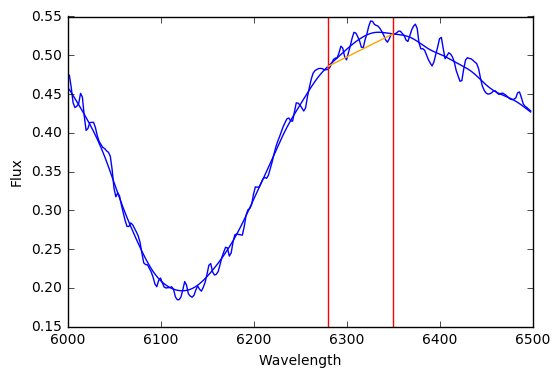

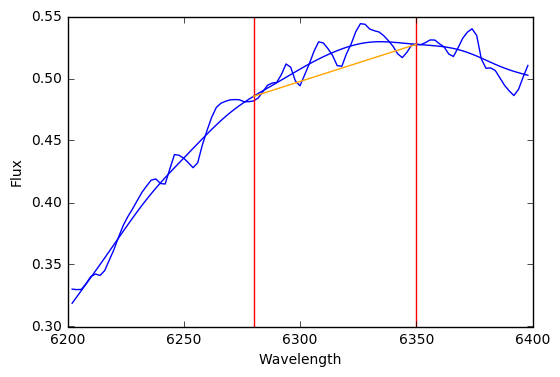

-1.4766271453
-----------------------------------------------------------------------------------------
42 | 2002fb | N


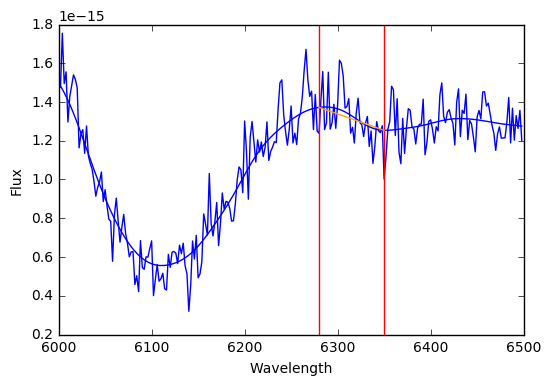

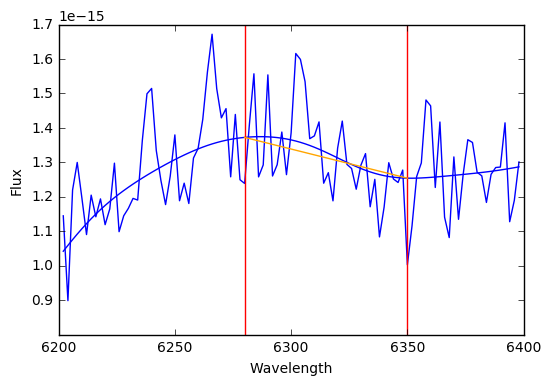

-0.481631721468
-----------------------------------------------------------------------------------------
43 | 2002ha | N


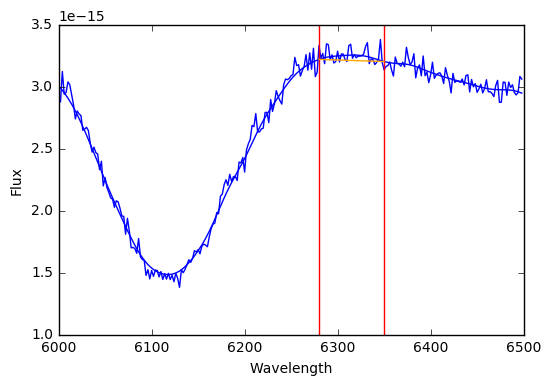

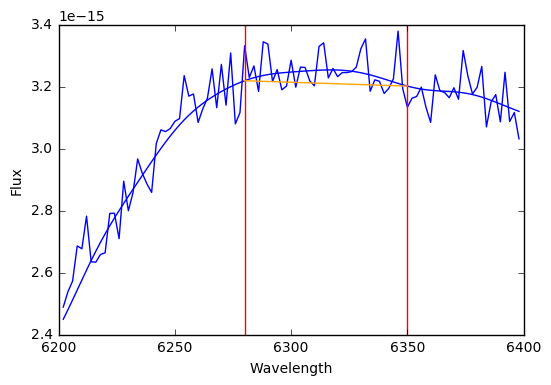

-0.863678828319
-----------------------------------------------------------------------------------------
44 | 2002he | N


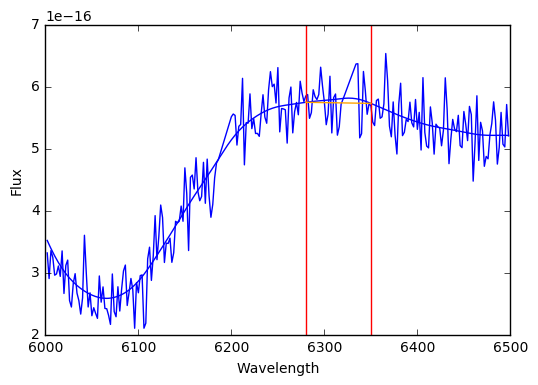

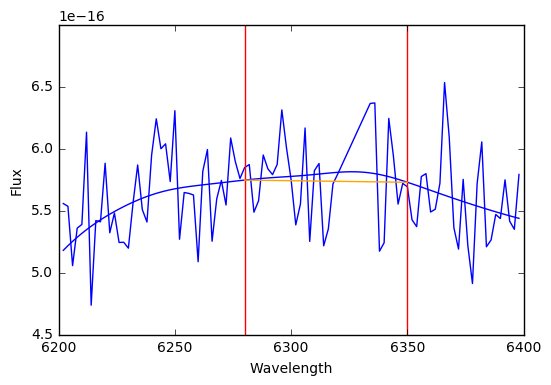

-0.914081352416
-----------------------------------------------------------------------------------------
45 | 2002hu | N


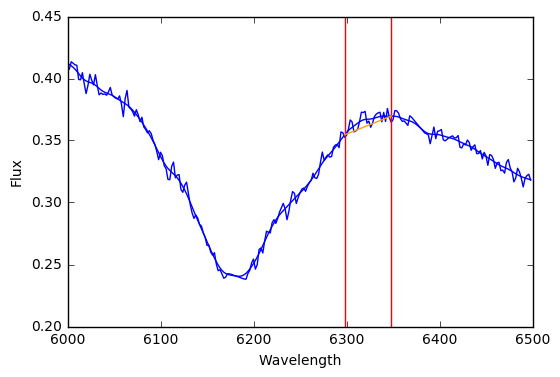

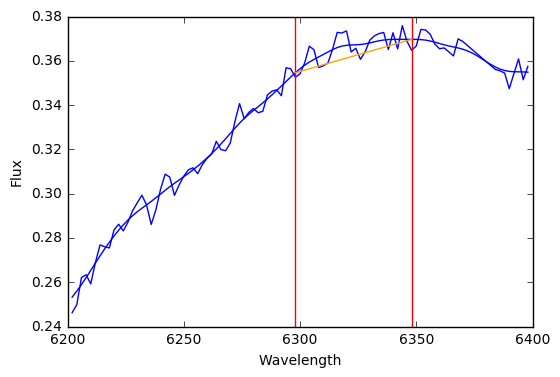

-0.527713967077
-----------------------------------------------------------------------------------------
46 | 2002hw | A


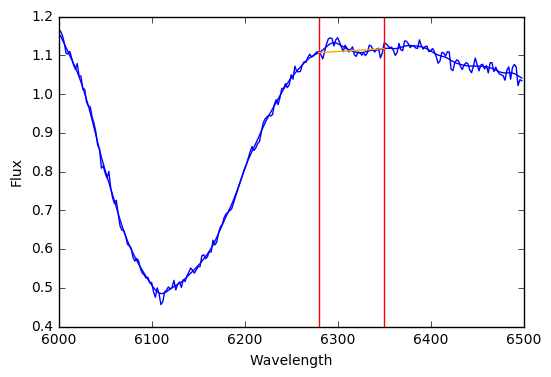

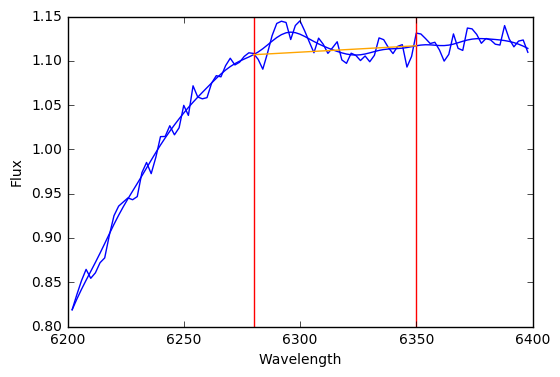

-0.276481122295
-----------------------------------------------------------------------------------------
47 | 2003cq | N


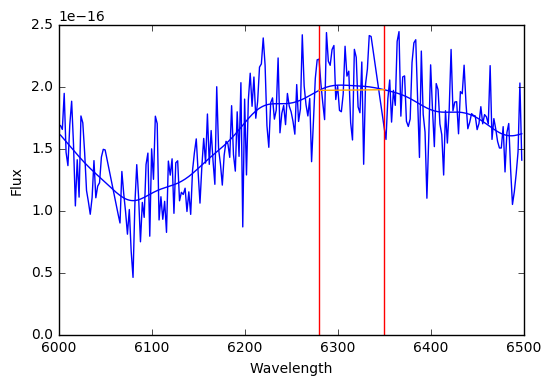

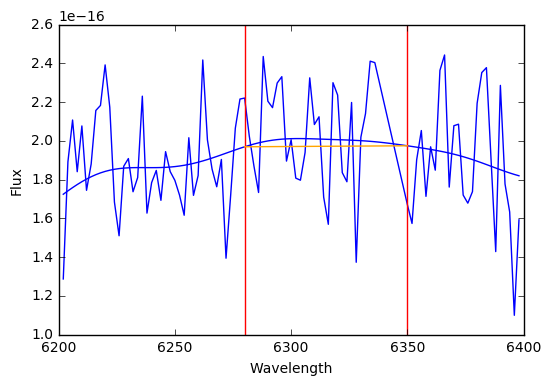

-2.21853328141
-----------------------------------------------------------------------------------------
48 | 2003du | F


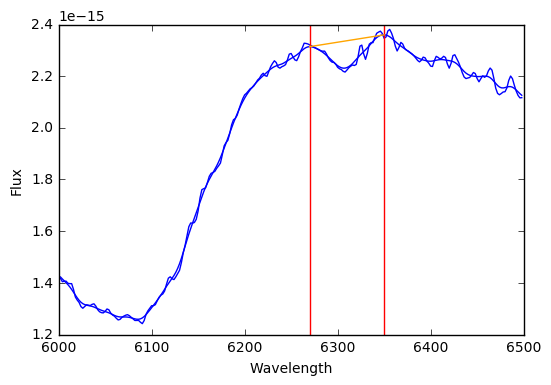

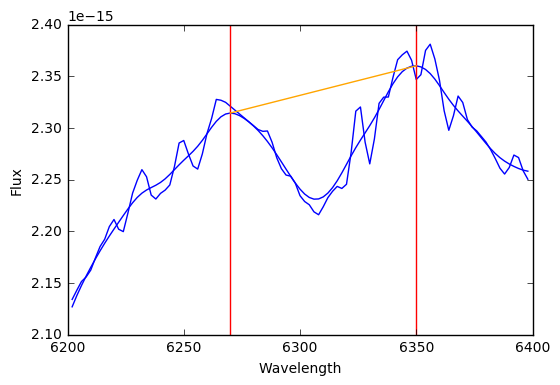

1.7390817948
-----------------------------------------------------------------------------------------
49 | 2003iv | N


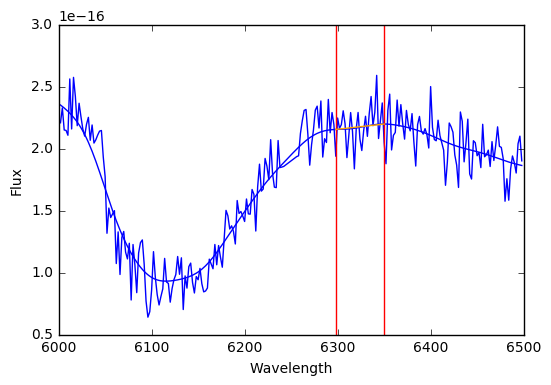

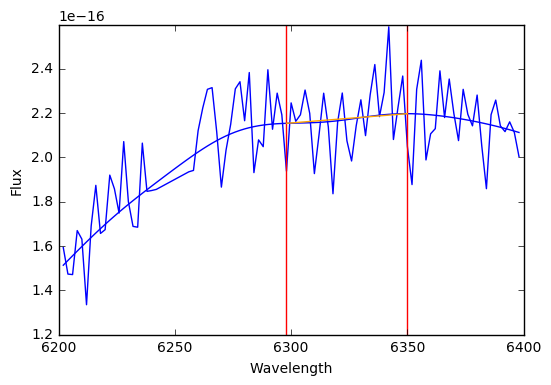

-0.249552000134
-----------------------------------------------------------------------------------------
50 | 2003kf | A


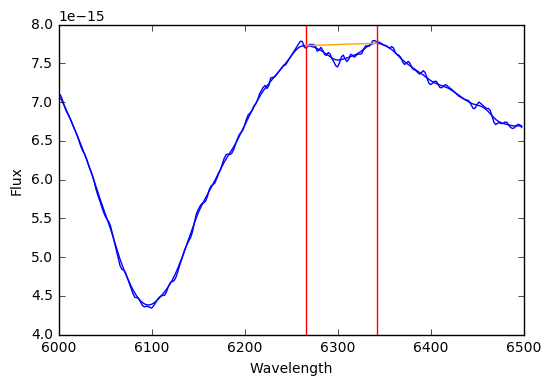

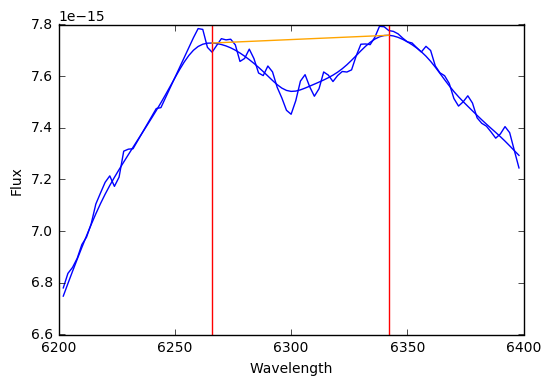

1.00968411692
-----------------------------------------------------------------------------------------
51 | 2003u | F


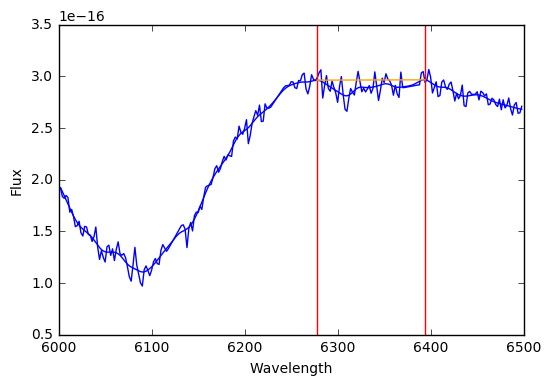

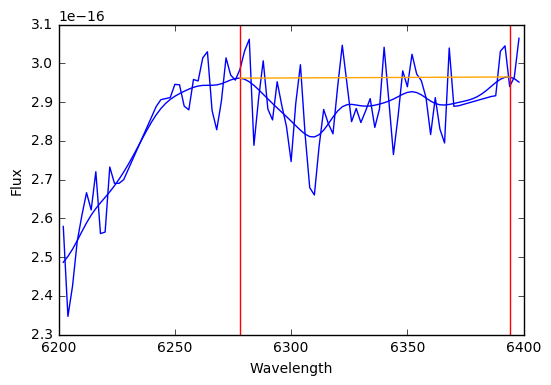

2.49870746785
-----------------------------------------------------------------------------------------
52 | 2003w | N


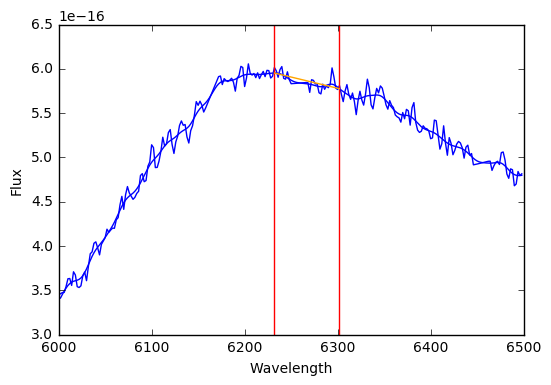

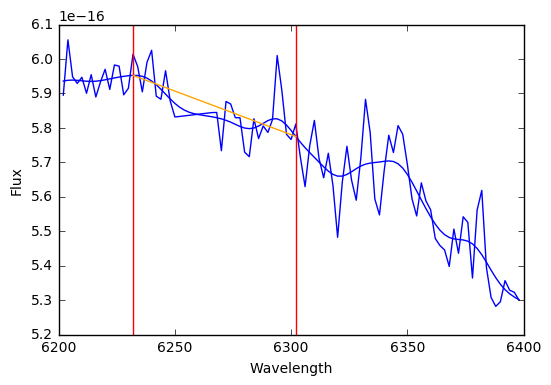

0.120135125146
-----------------------------------------------------------------------------------------
53 | 2004as | N


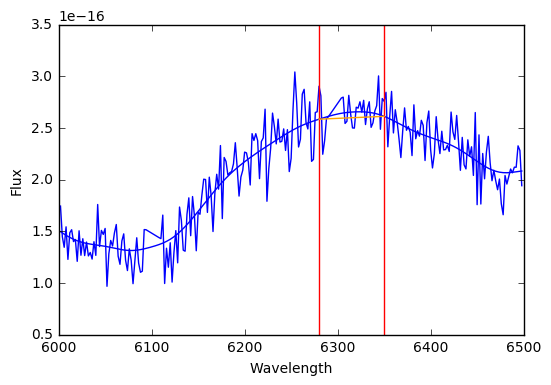

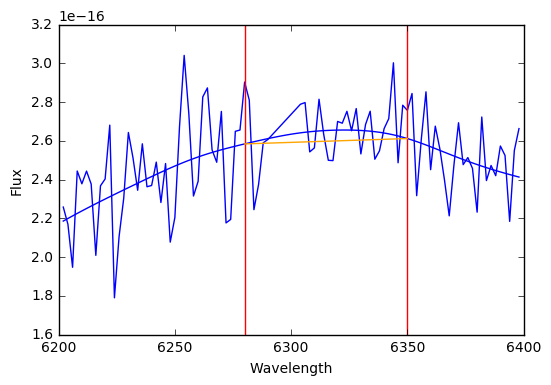

-1.60870650893
-----------------------------------------------------------------------------------------
54 | 2004dt | N


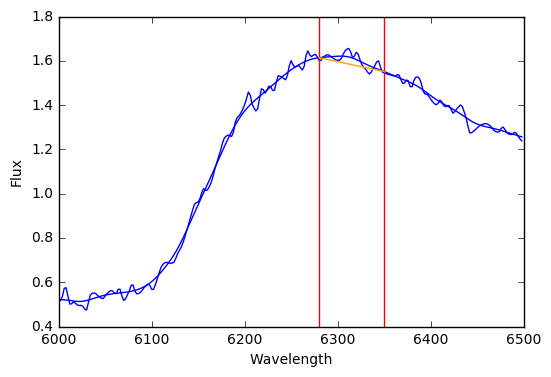

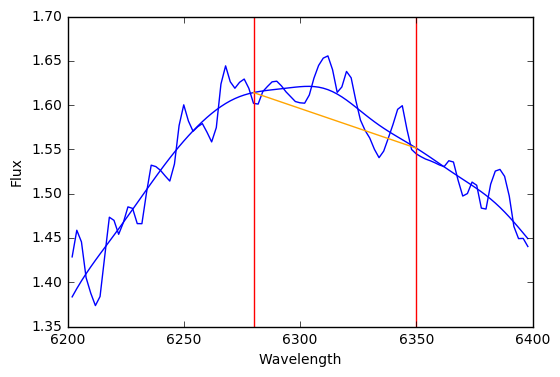

-0.858549626773
-----------------------------------------------------------------------------------------
55 | 2004ef | N


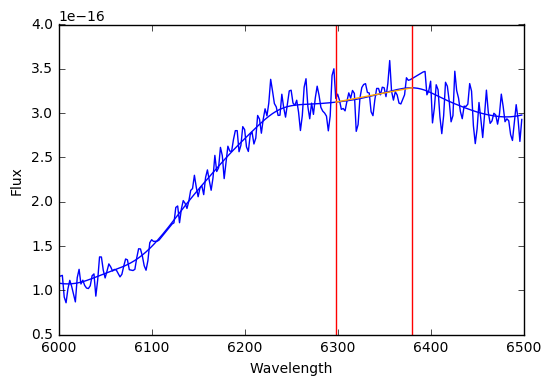

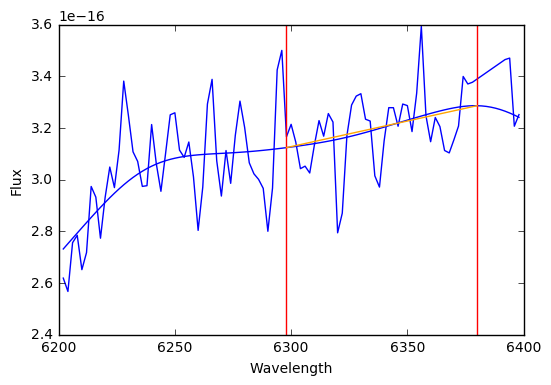

0.15701603746
-----------------------------------------------------------------------------------------
56 | 2004eo | N


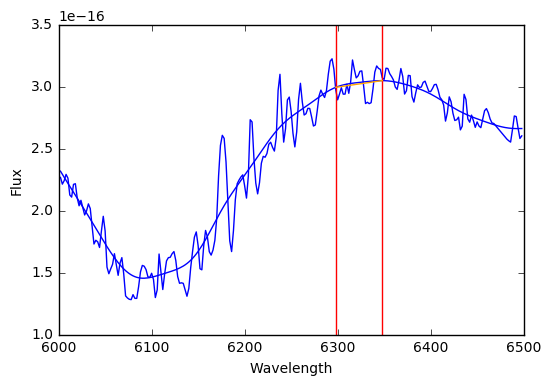

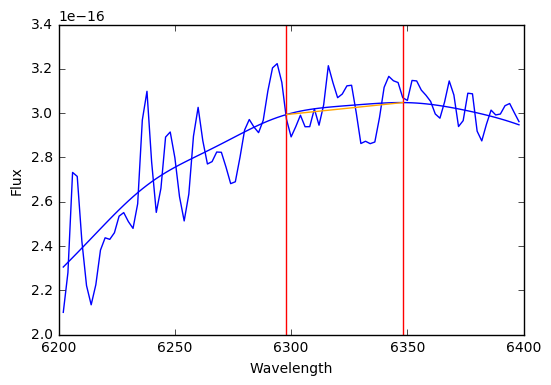

0.0156792269132
-----------------------------------------------------------------------------------------
57 | 2004ey | A


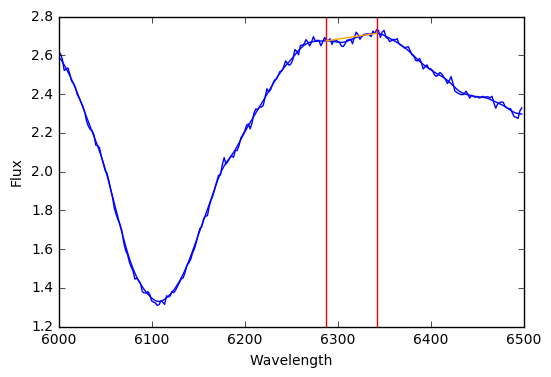

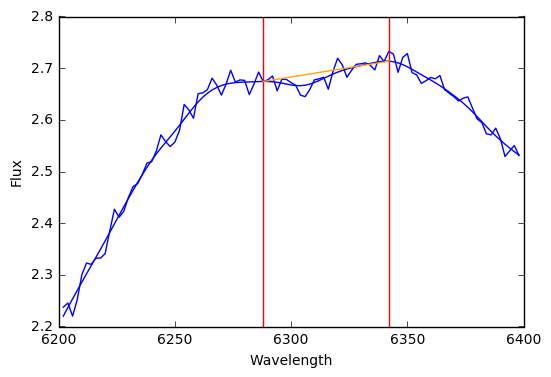

0.152347654931
-----------------------------------------------------------------------------------------
58 | 2004fu | N


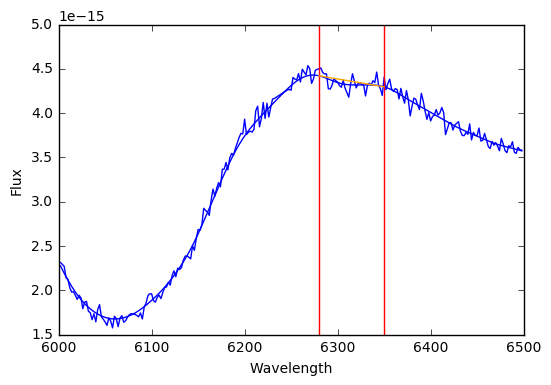

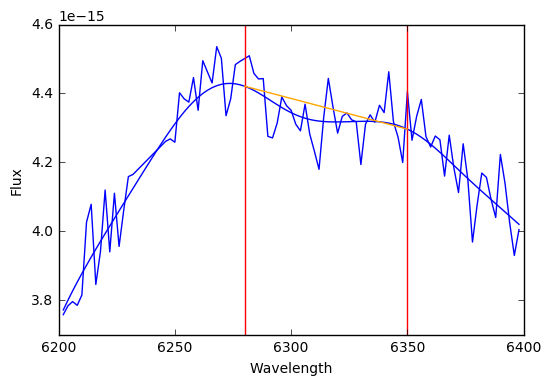

0.346544007099
-----------------------------------------------------------------------------------------
59 | 2004gs | N


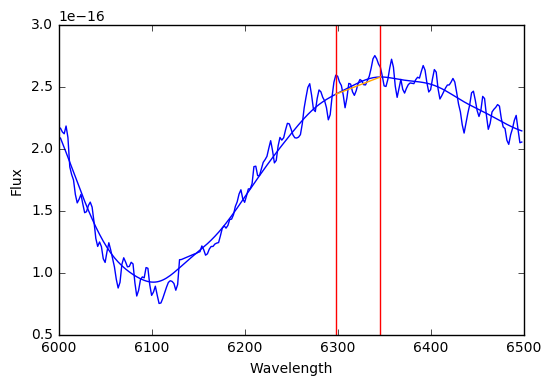

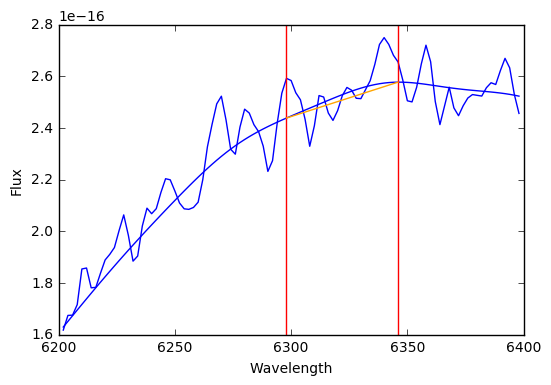

-0.745950790405
-----------------------------------------------------------------------------------------
60 | 2004gu | N


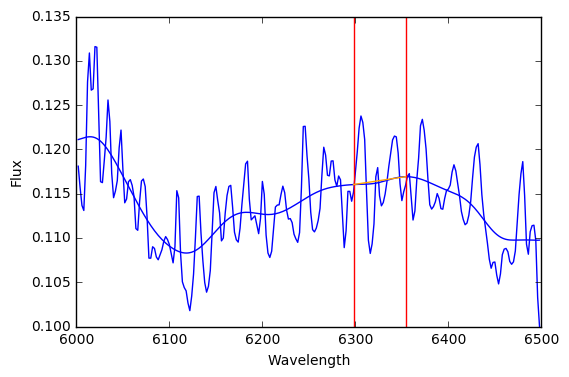

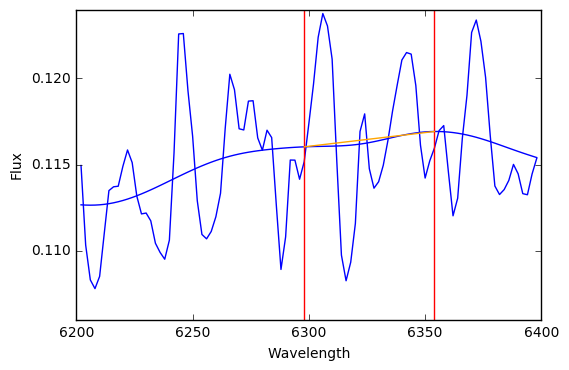

-0.194249649865
-----------------------------------------------------------------------------------------
61 | 2005ag | N


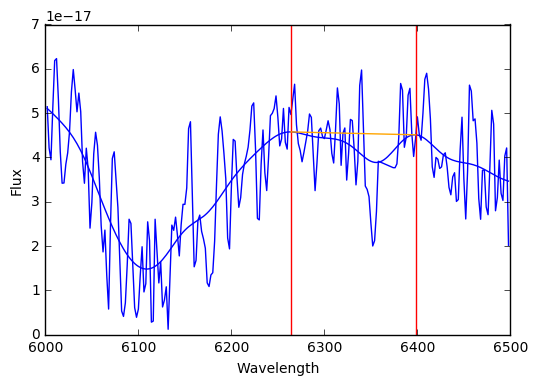

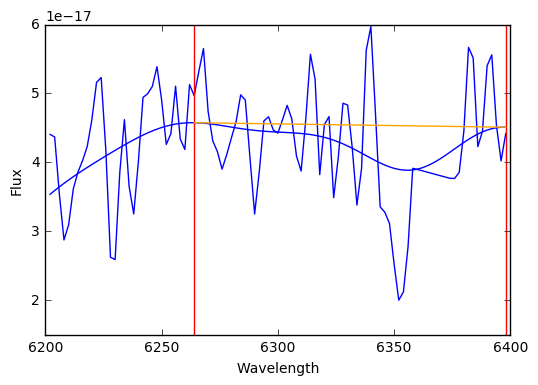

8.20372361002
-----------------------------------------------------------------------------------------
62 | 2005bl | F


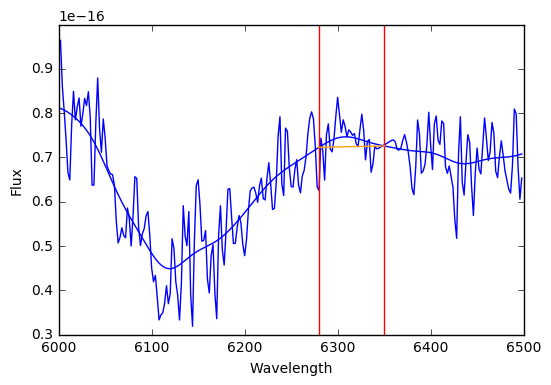

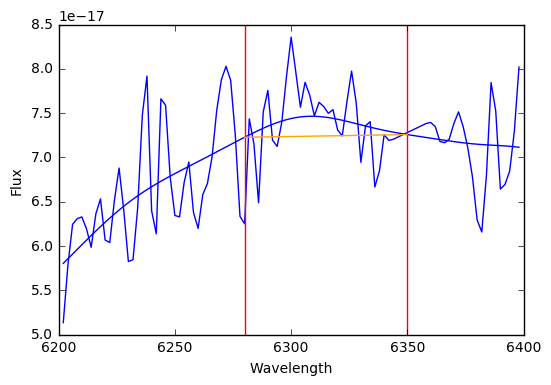

-1.52467768471
-----------------------------------------------------------------------------------------
63 | 2005bo | N


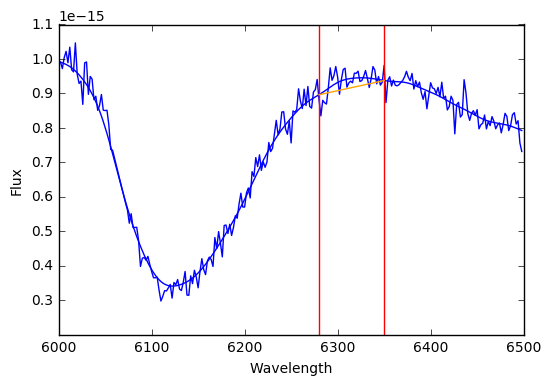

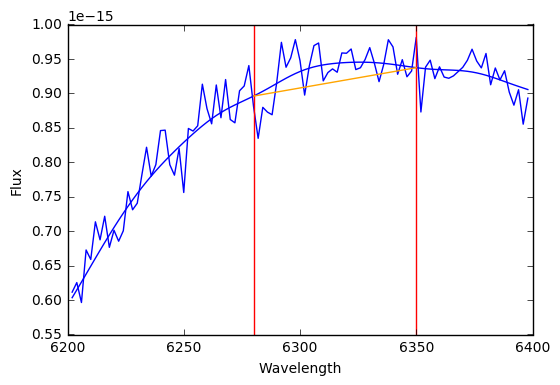

-1.42077181763
-----------------------------------------------------------------------------------------
64 | 2005cf | A


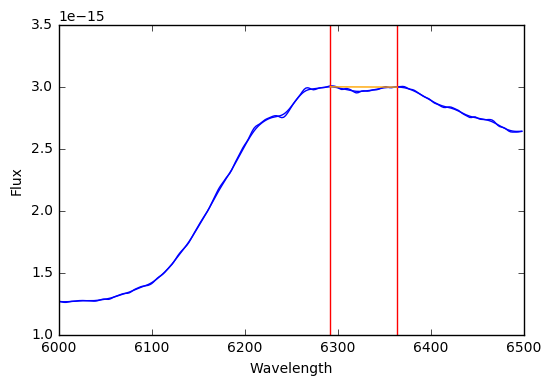

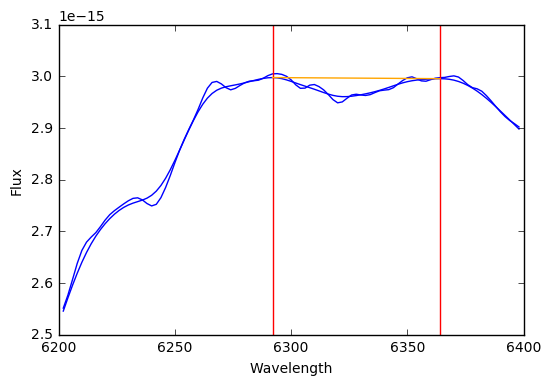

0.407509779759
-----------------------------------------------------------------------------------------
65 | 2005el | A


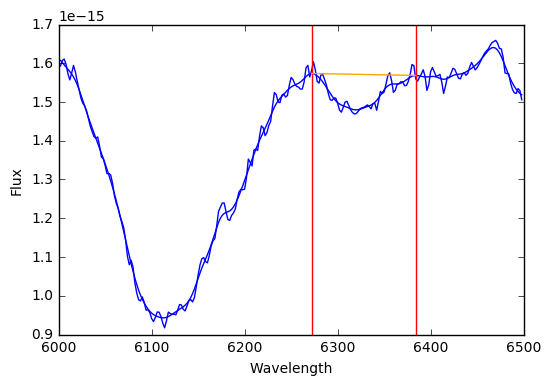

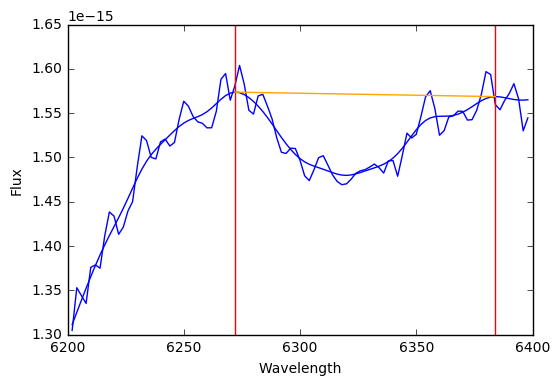

3.41767636646
-----------------------------------------------------------------------------------------
66 | 2005eq | N


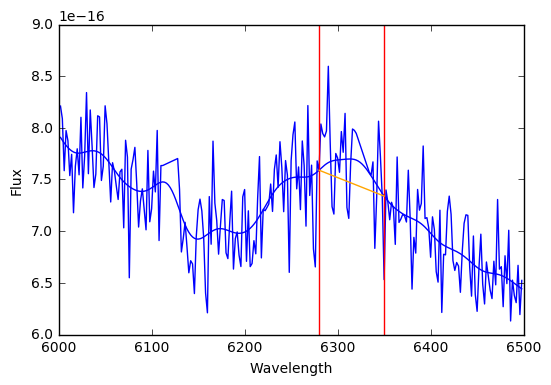

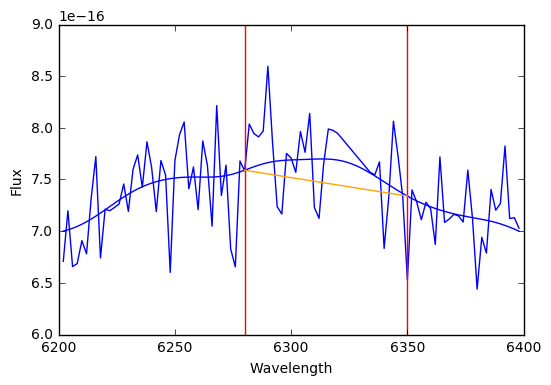

-2.1232834234
-----------------------------------------------------------------------------------------
67 | 2005eu | A


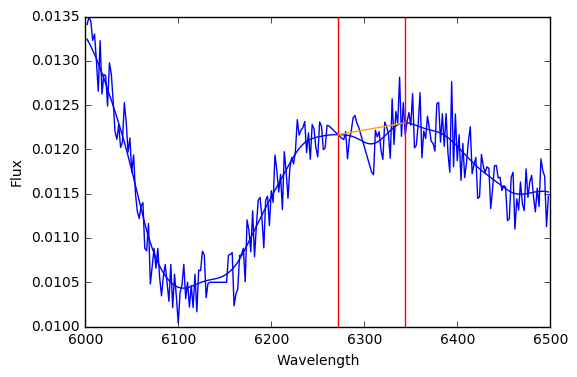

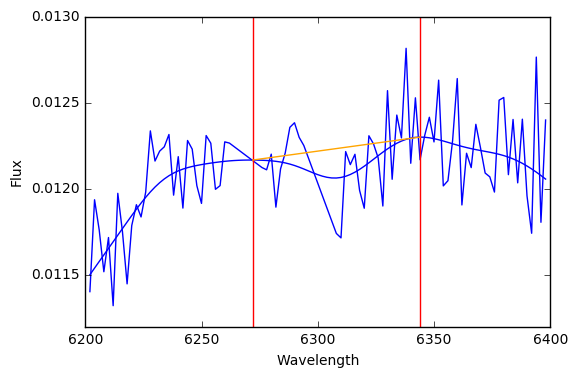

0.458440399978
-----------------------------------------------------------------------------------------
68 | 2005hc | N


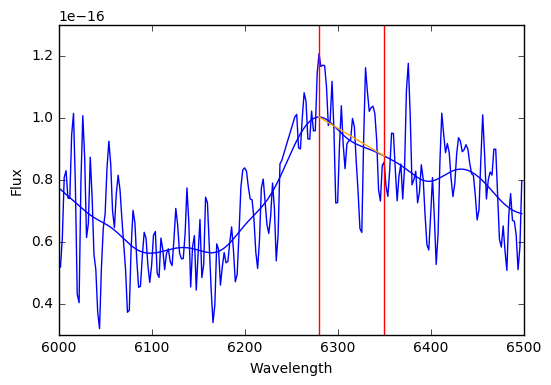

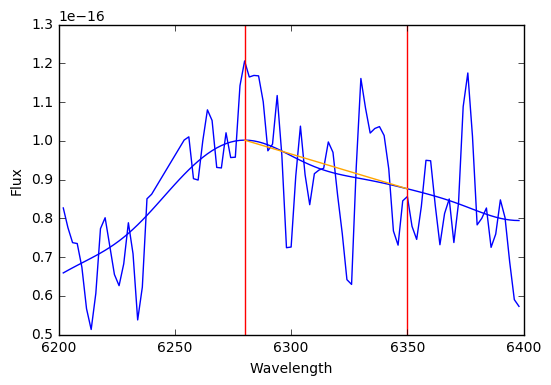

-0.236259950442
-----------------------------------------------------------------------------------------
69 | 2005iq | A


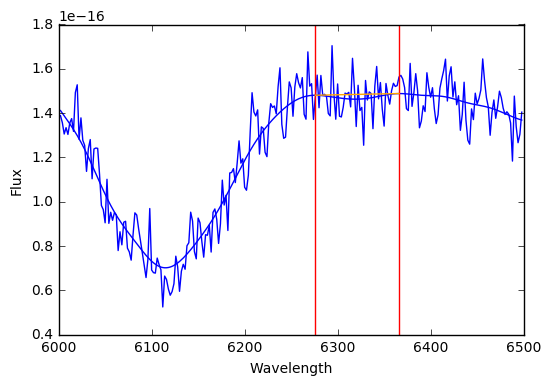

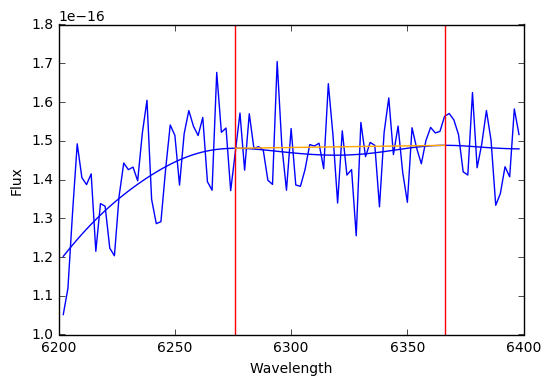

0.584933814213
-----------------------------------------------------------------------------------------
70 | 2005ke | N


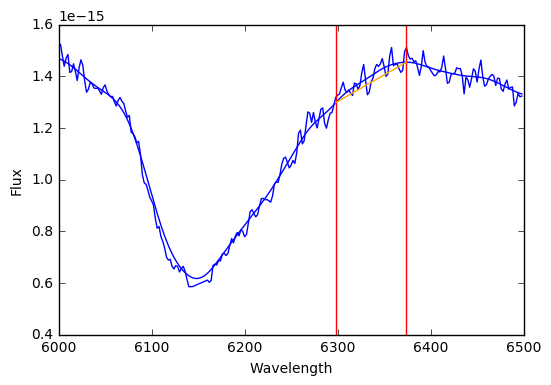

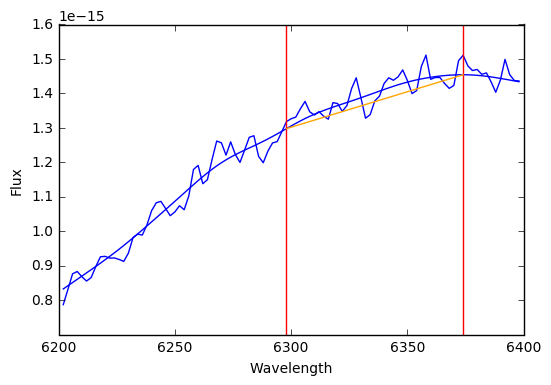

-1.32022585856
-----------------------------------------------------------------------------------------
71 | 2005ki | A


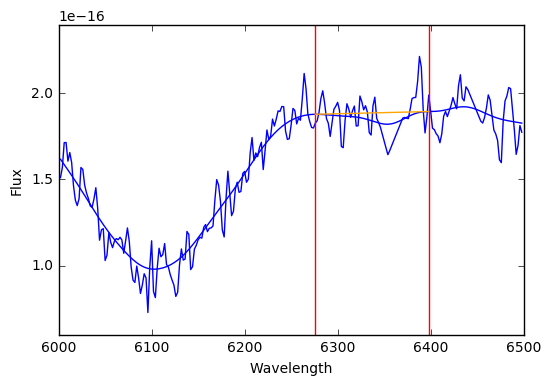

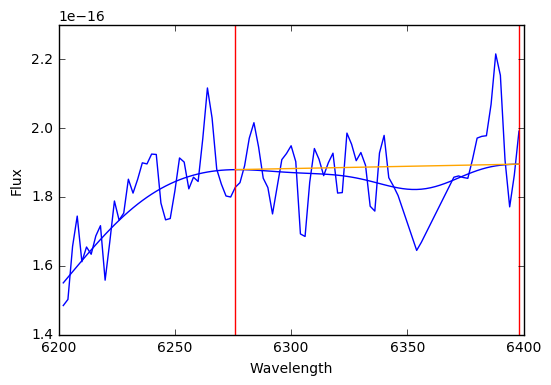

1.40279564646
-----------------------------------------------------------------------------------------
72 | 2005lz | N


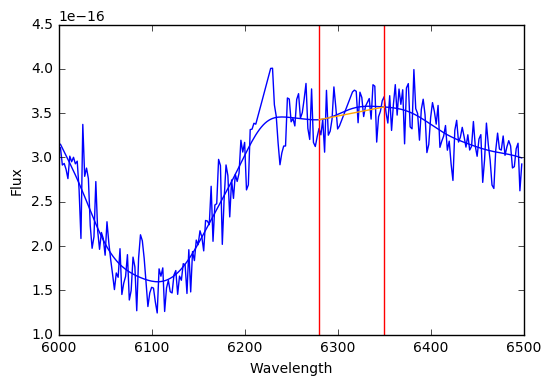

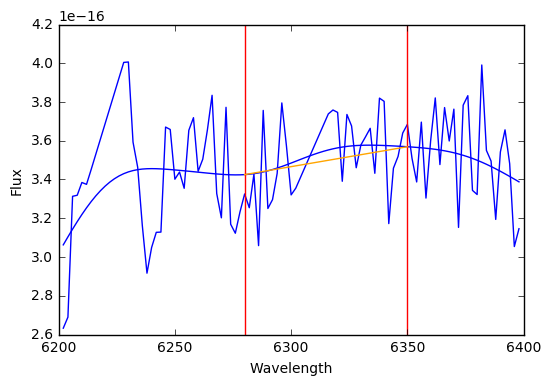

-0.631992088617
-----------------------------------------------------------------------------------------
73 | 2005m | N


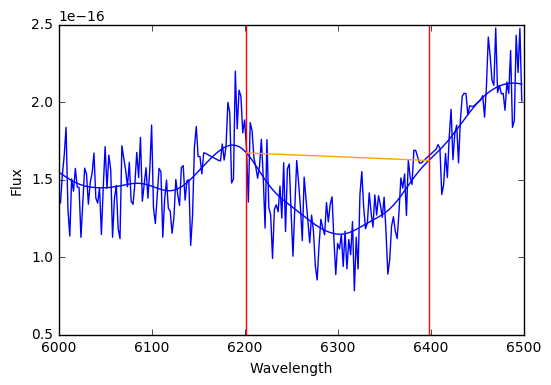

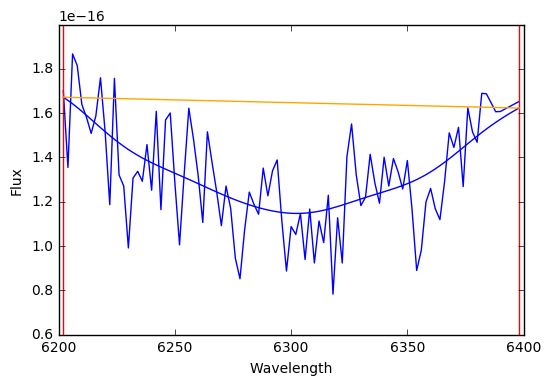

38.5612739551
-----------------------------------------------------------------------------------------
74 | 2005ms | N


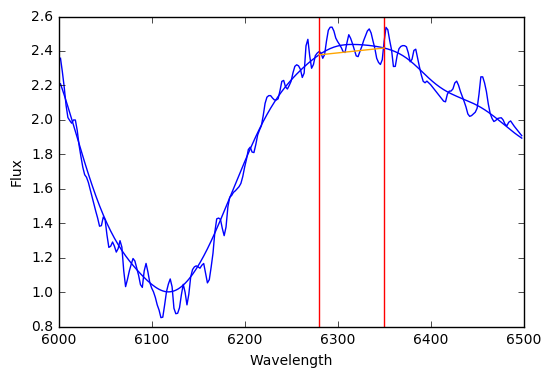

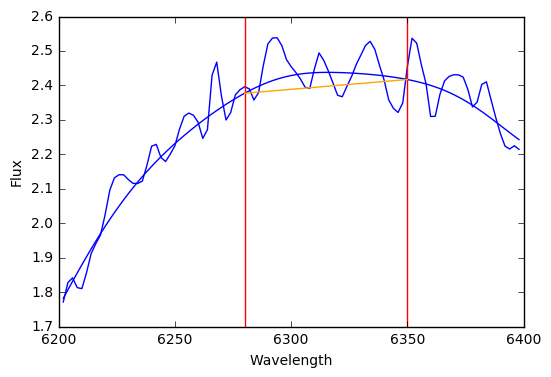

-1.1293593713
-----------------------------------------------------------------------------------------
75 | 2005na | F


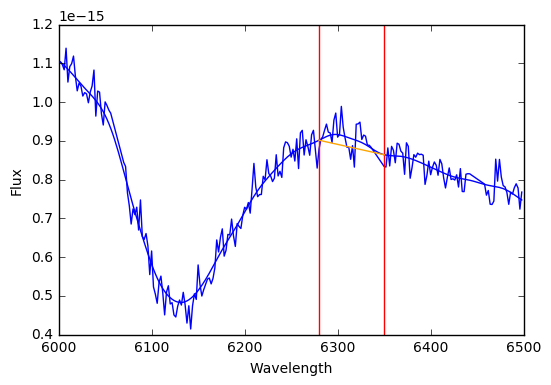

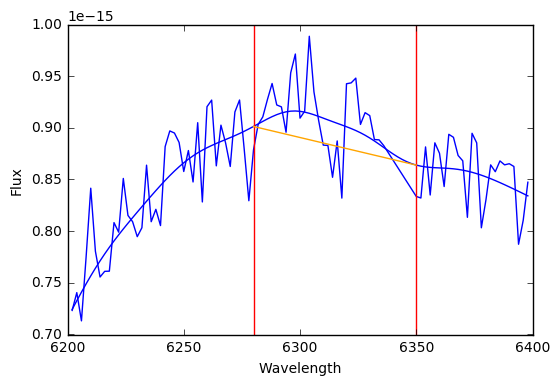

-1.52747024644
-----------------------------------------------------------------------------------------
76 | 2005w | N


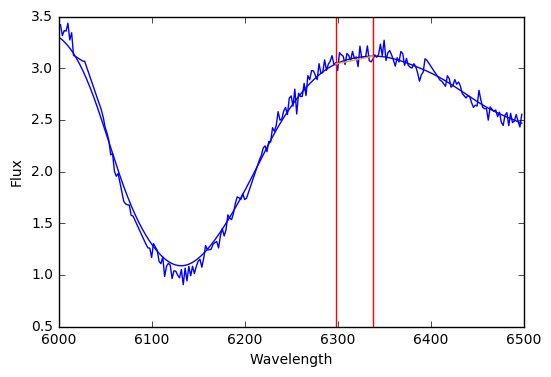

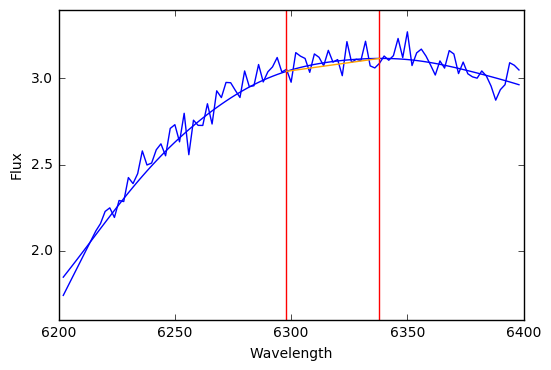

-0.324857257424
-----------------------------------------------------------------------------------------
77 | 2006ax | F


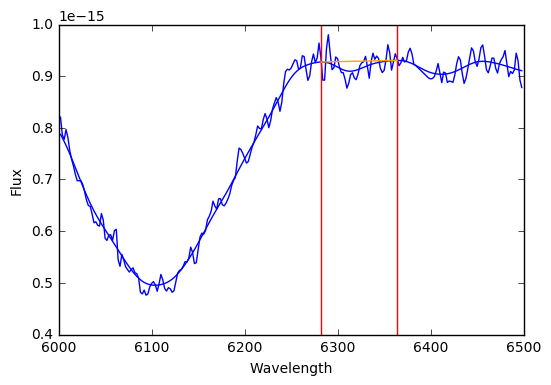

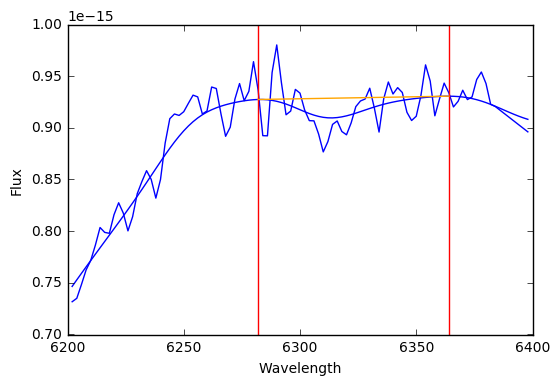

0.734325690184
-----------------------------------------------------------------------------------------
78 | 2006bt | F


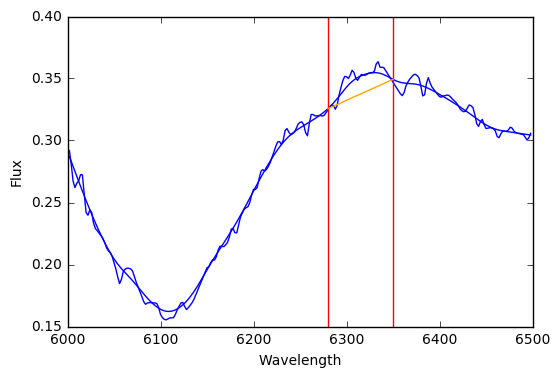

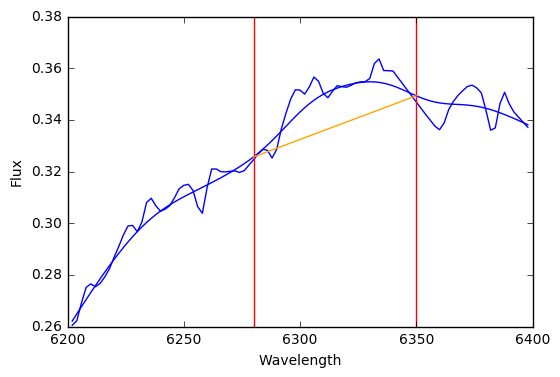

-2.37786790041
-----------------------------------------------------------------------------------------
79 | 2006cp | N


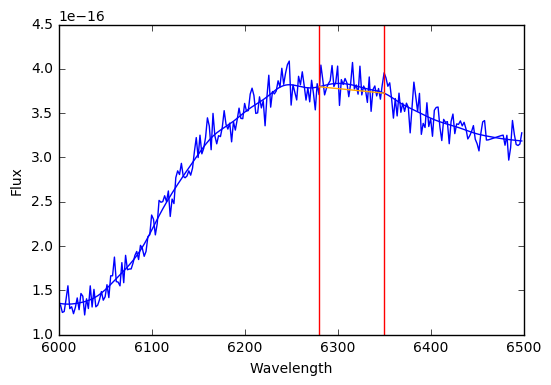

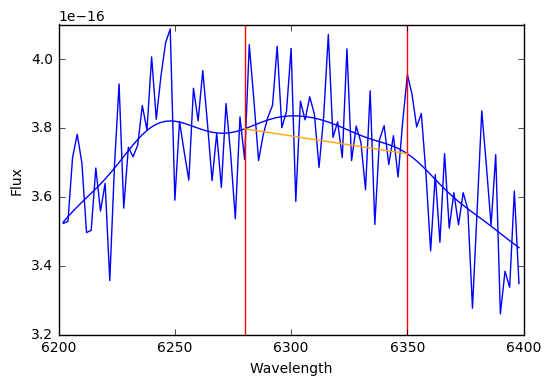

-0.948898716386
-----------------------------------------------------------------------------------------
80 | 2006cq | N


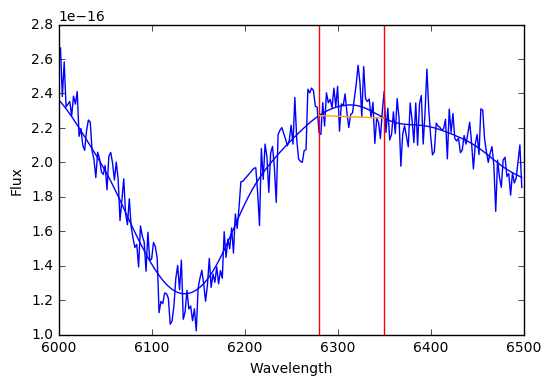

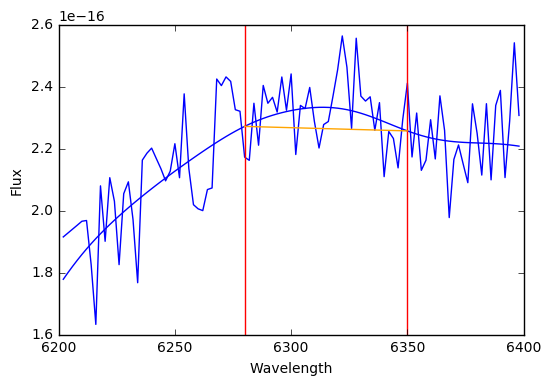

-1.84117712951
-----------------------------------------------------------------------------------------
81 | 2006cs | F


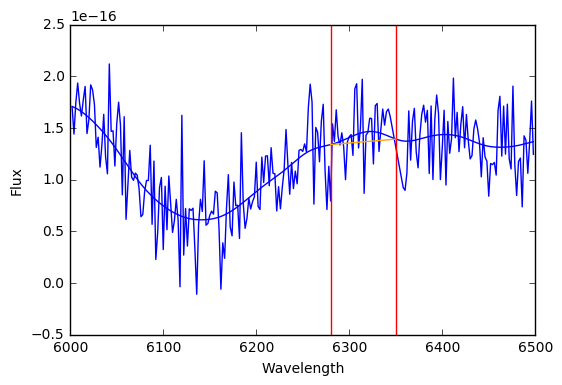

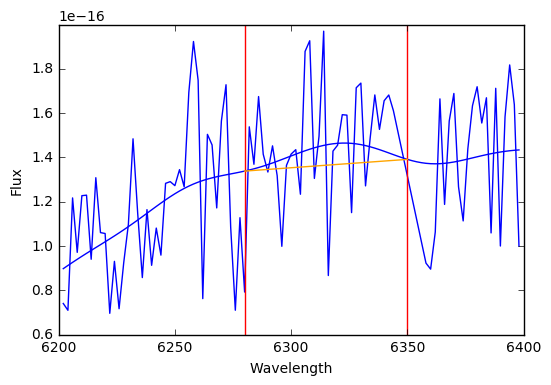

-5.53217260093
-----------------------------------------------------------------------------------------
82 | 2006d | A


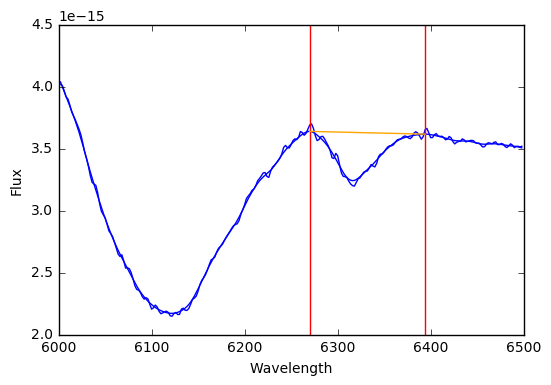

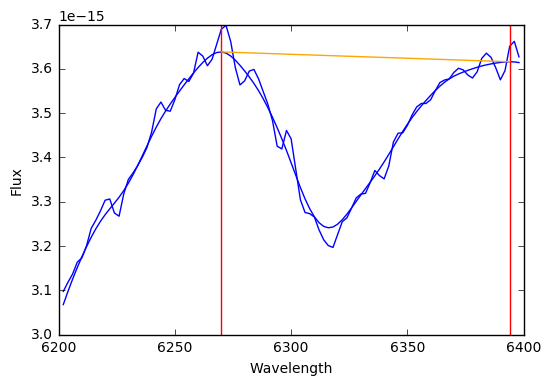

5.53605592918
-----------------------------------------------------------------------------------------
83 | 2006ef | N


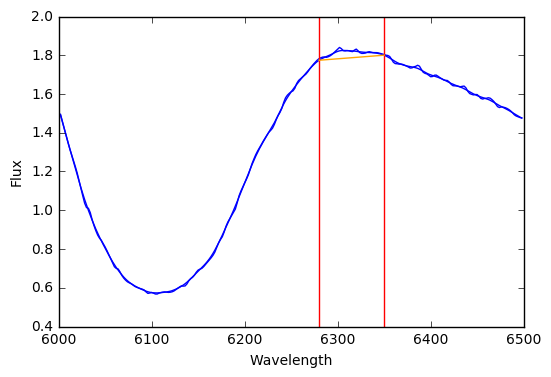

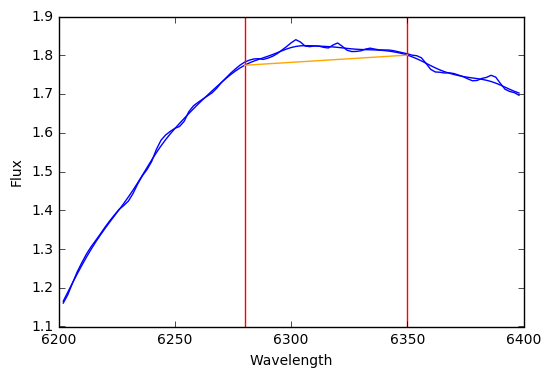

-1.0173270514
-----------------------------------------------------------------------------------------
84 | 2006ej | N


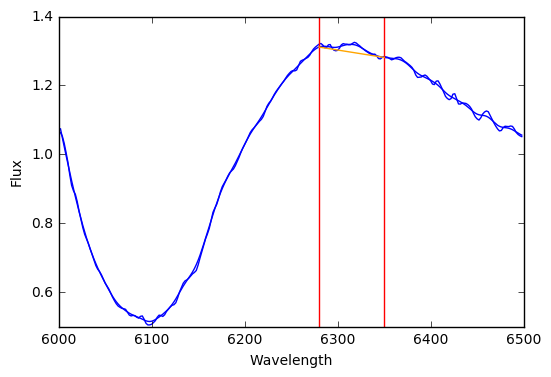

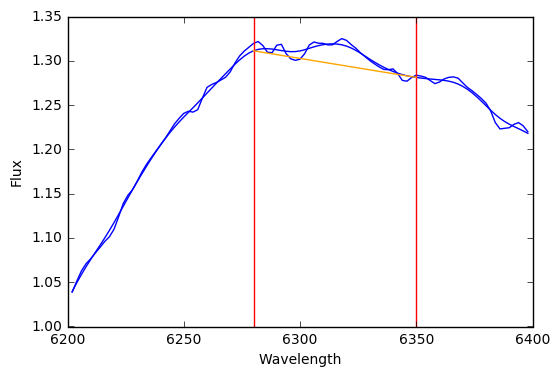

-0.557272758558
-----------------------------------------------------------------------------------------
85 | 2006et | N


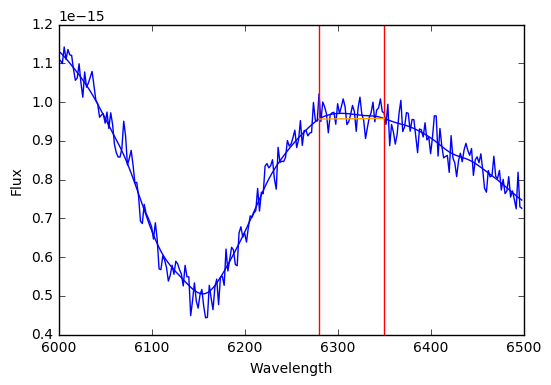

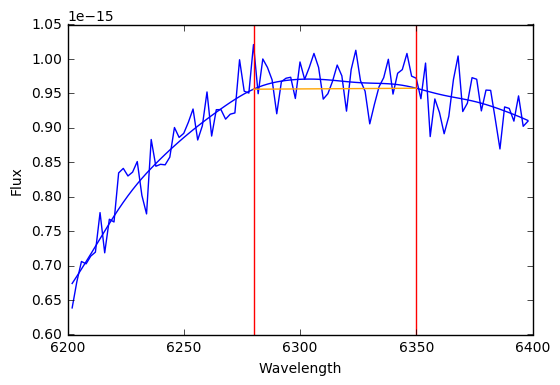

-0.997284617801
-----------------------------------------------------------------------------------------
86 | 2006gt | N


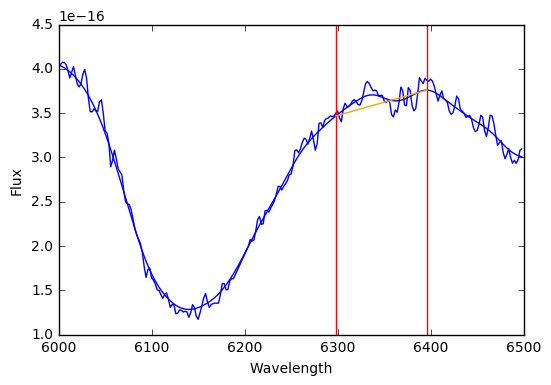

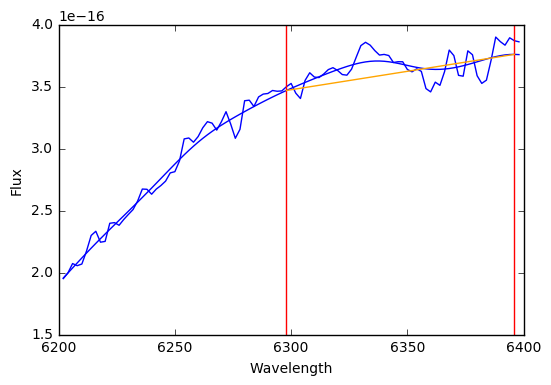

-1.29284423183
-----------------------------------------------------------------------------------------
87 | 2006kf | N


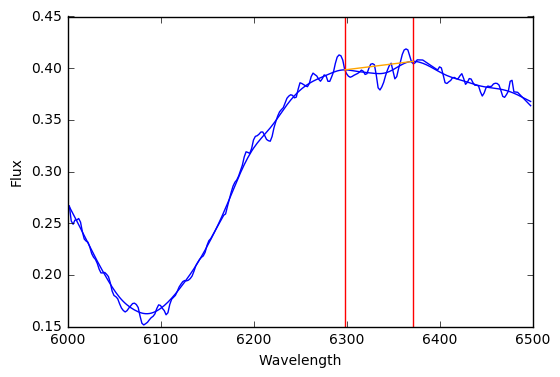

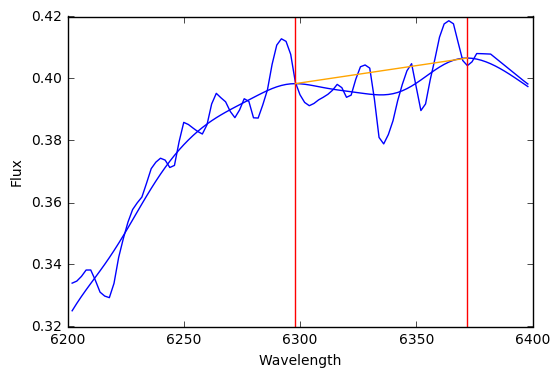

0.787540665524
-----------------------------------------------------------------------------------------
88 | 2006le | N


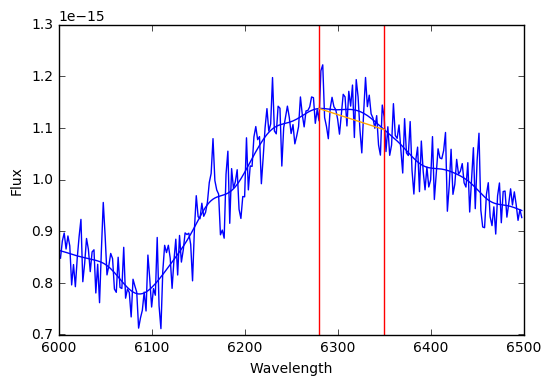

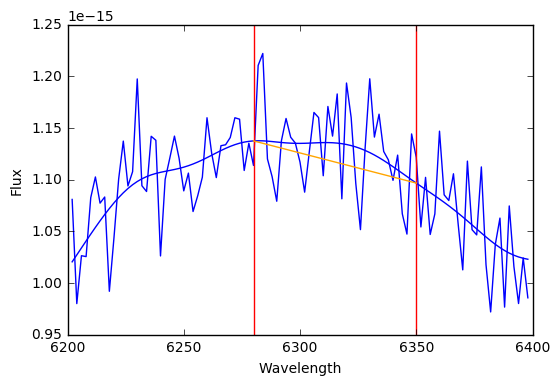

-0.944136235723
-----------------------------------------------------------------------------------------
89 | 2006n | N


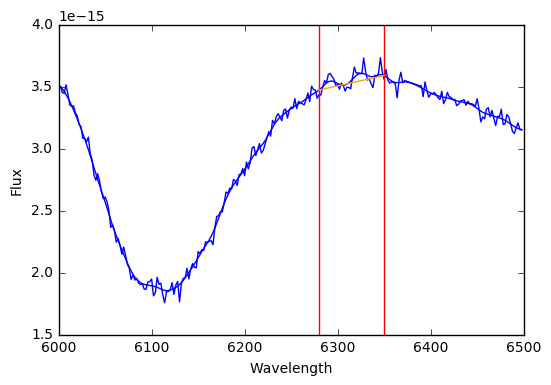

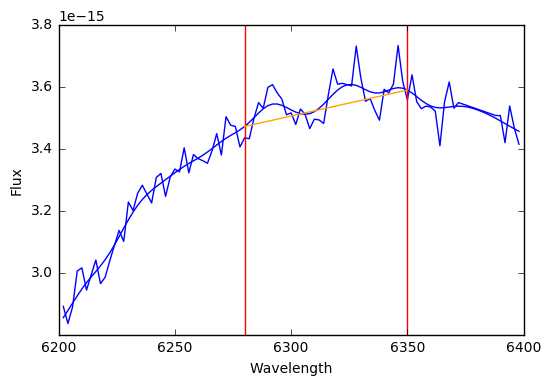

-0.587566275395
-----------------------------------------------------------------------------------------
90 | 2006or | N


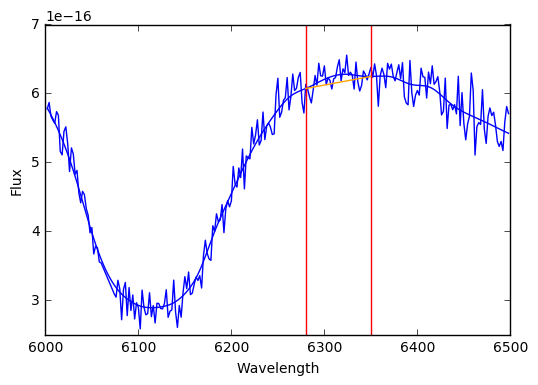

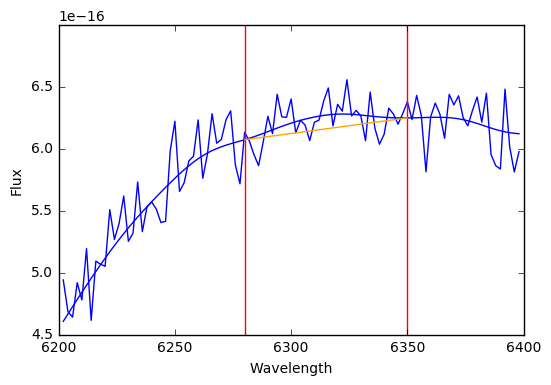

-0.782319289102
-----------------------------------------------------------------------------------------
91 | 2006os | N


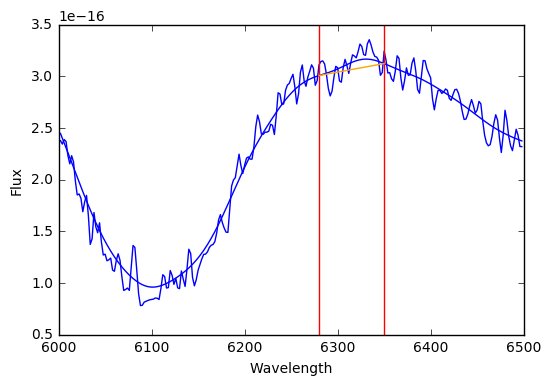

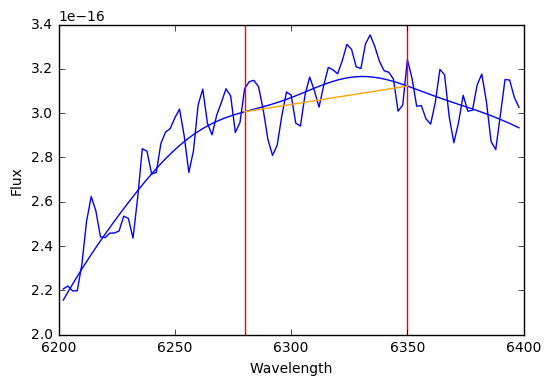

-1.33420682078
-----------------------------------------------------------------------------------------
92 | 2006s | N


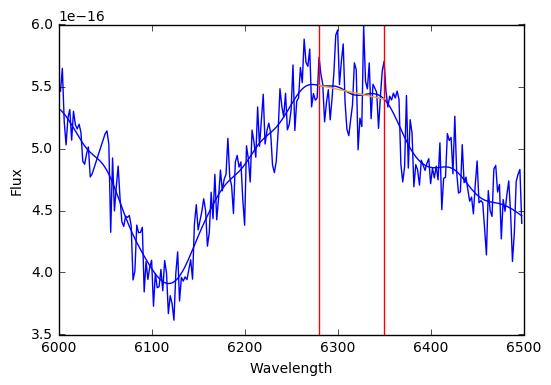

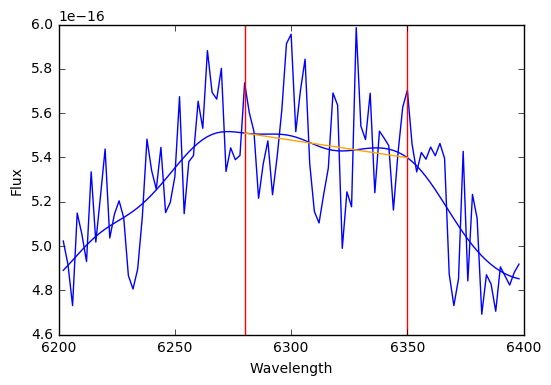

-0.274279800615
-----------------------------------------------------------------------------------------
93 | 2006sr | N


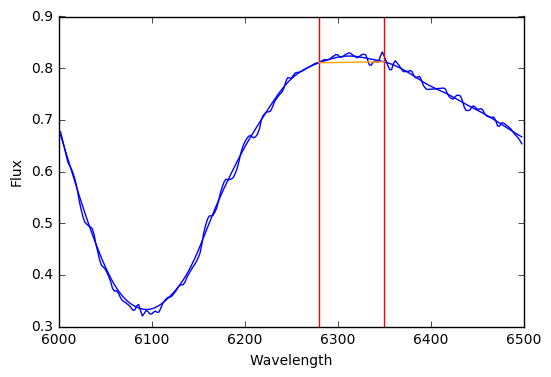

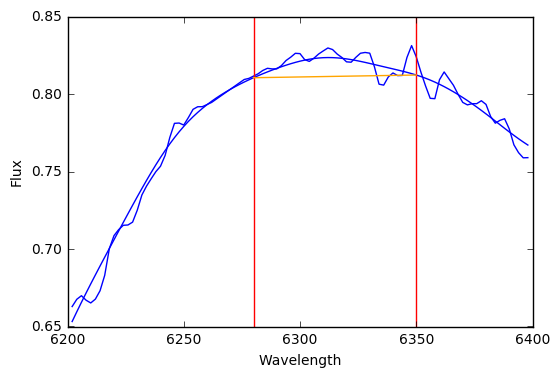

-0.783201859388
-----------------------------------------------------------------------------------------
94 | 2006x | N


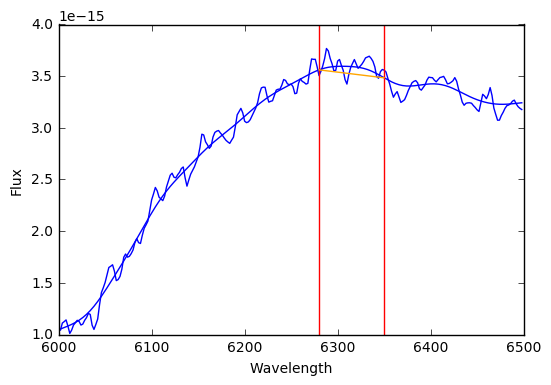

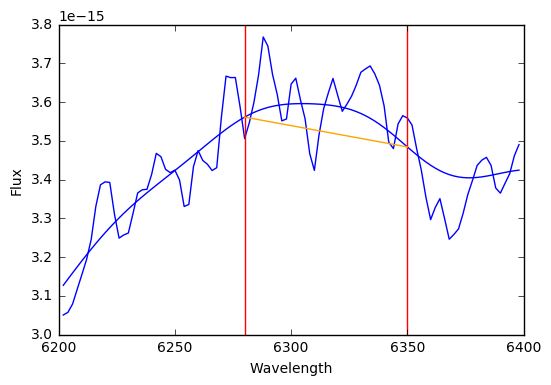

-1.59318480825
-----------------------------------------------------------------------------------------
95 | 2006x | N


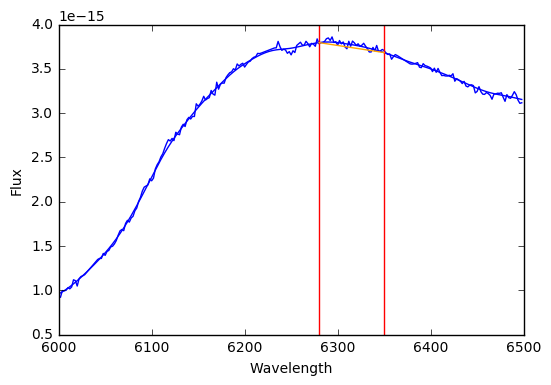

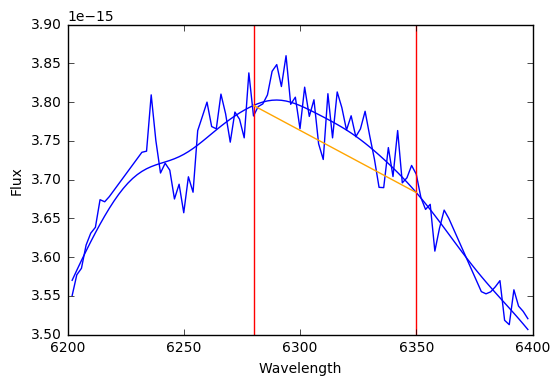

-0.582928988035
-----------------------------------------------------------------------------------------
96 | 2007a | F


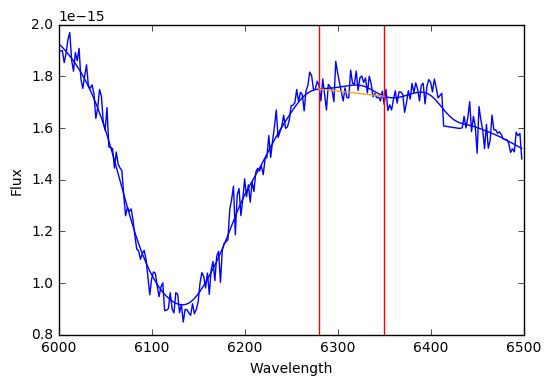

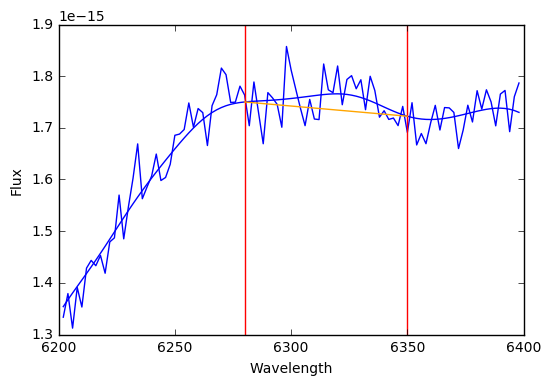

-0.727118666375
-----------------------------------------------------------------------------------------
97 | 2007ax | N


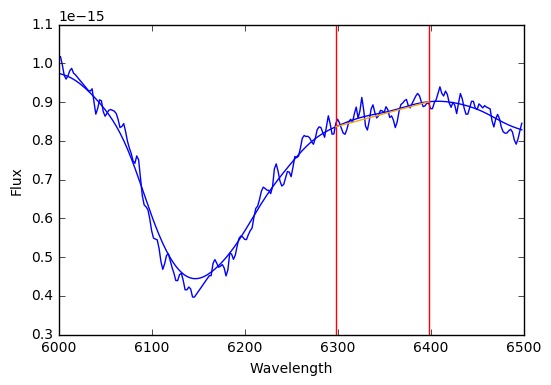

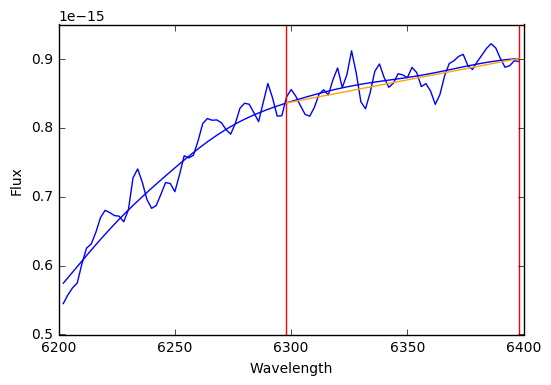

-0.490038782897
-----------------------------------------------------------------------------------------
98 | 2007bc | F


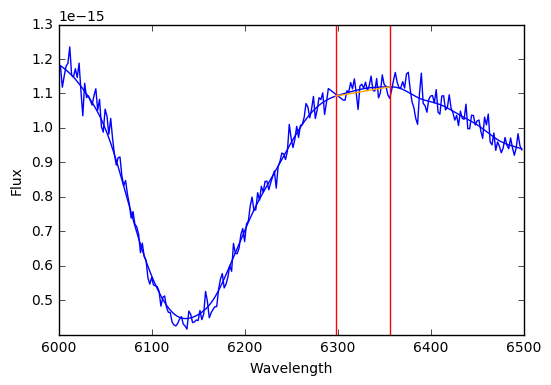

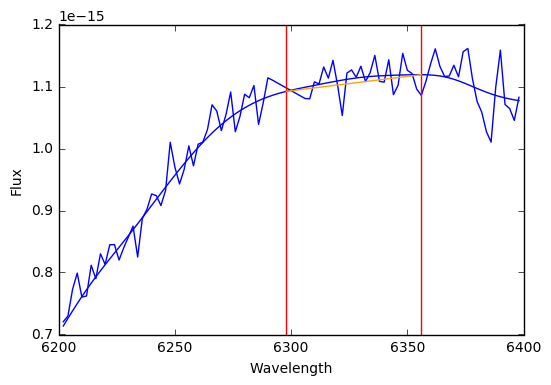

-0.233729168698
-----------------------------------------------------------------------------------------
99 | 2007bd | N


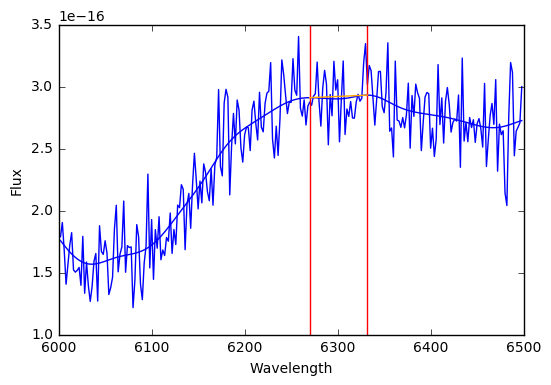

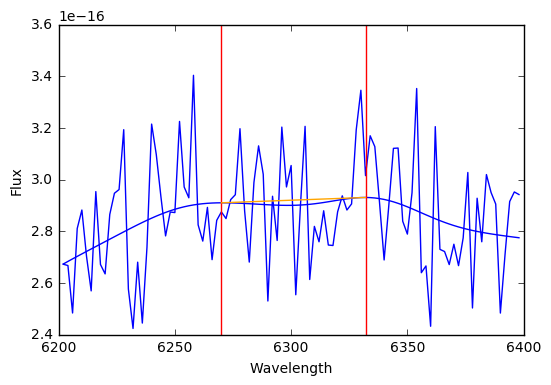

0.112464180548
-----------------------------------------------------------------------------------------
100 | 2007bm | A


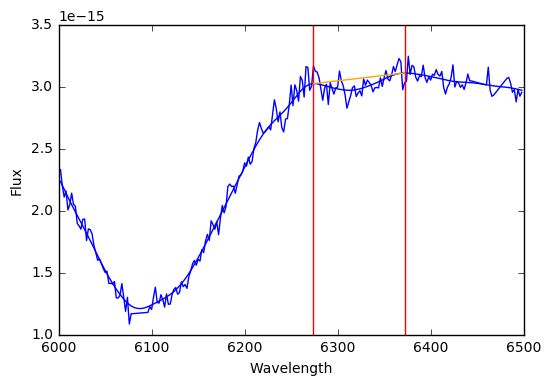

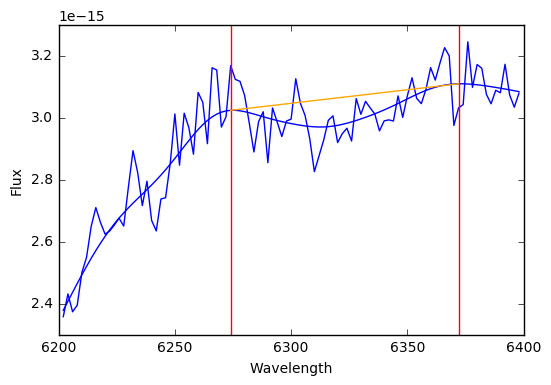

1.46863921593
-----------------------------------------------------------------------------------------
101 | 2007bz | N


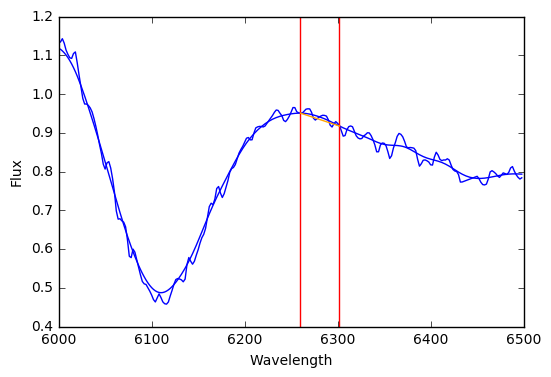

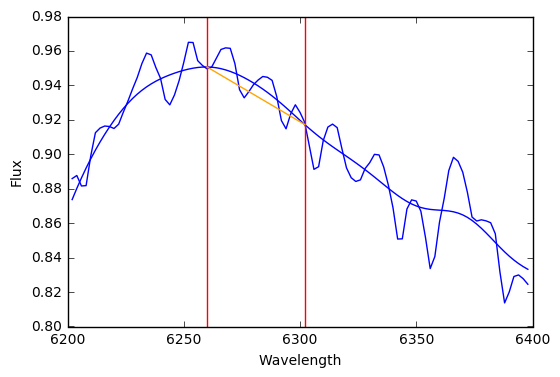

-0.27891717145
-----------------------------------------------------------------------------------------
102 | 2007ca | N


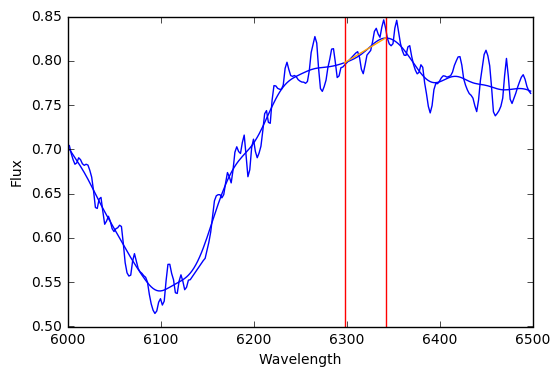

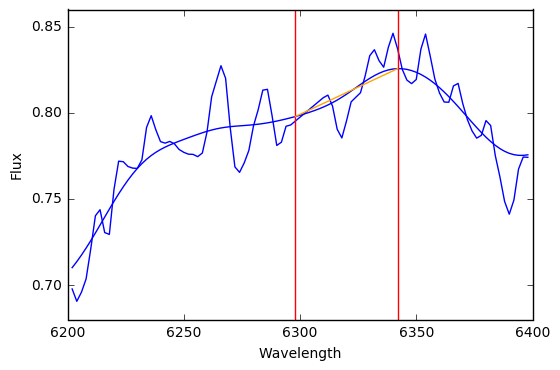

-0.0478950212131
-----------------------------------------------------------------------------------------
103 | 2007ci | N


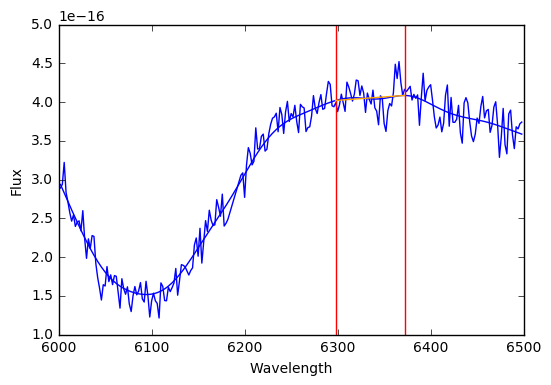

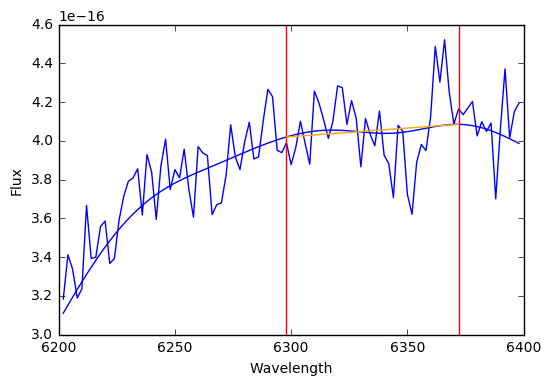

-0.152768742225
-----------------------------------------------------------------------------------------
104 | 2007co | N


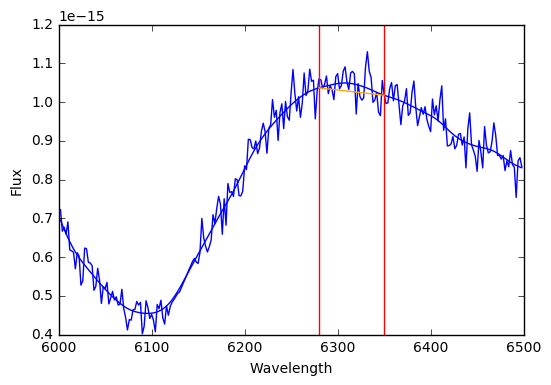

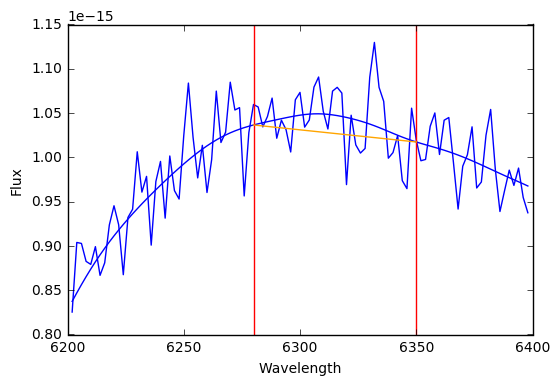

-1.02623133877
-----------------------------------------------------------------------------------------
105 | 2007cq | A


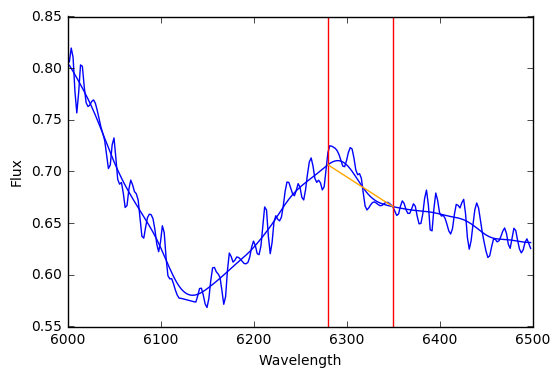

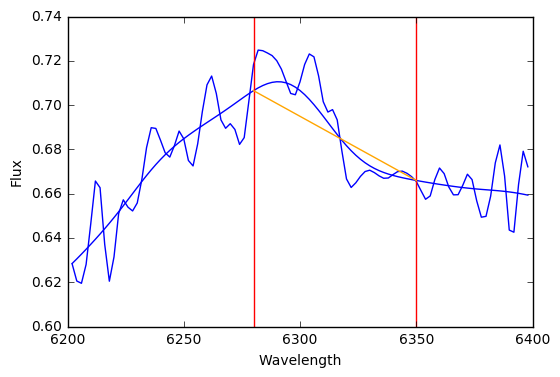

-0.570958747482
-----------------------------------------------------------------------------------------
106 | 2007f | A


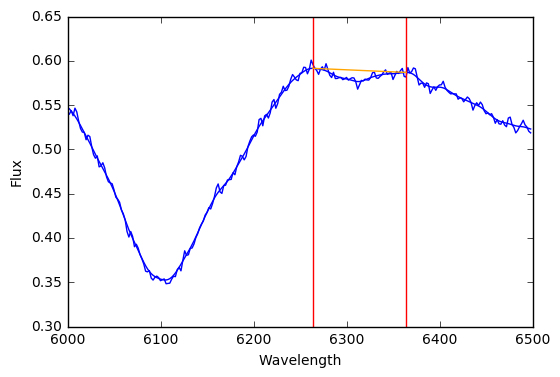

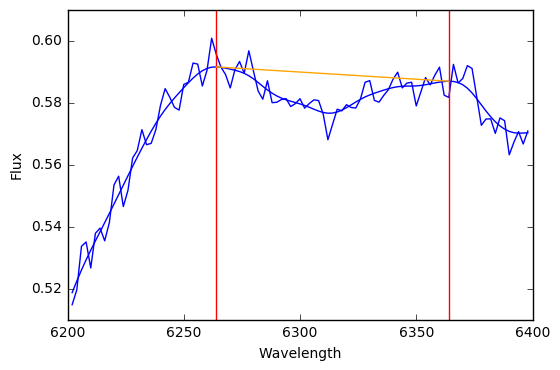

0.980238782574
-----------------------------------------------------------------------------------------
107 | 2007le | N


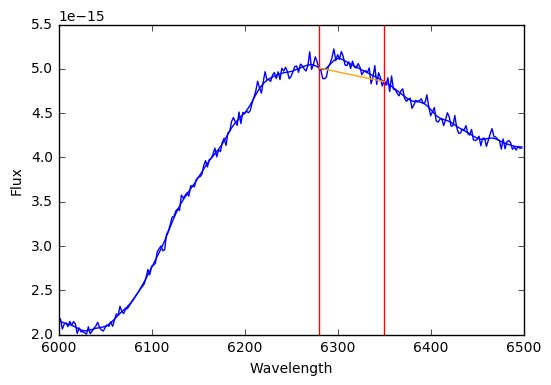

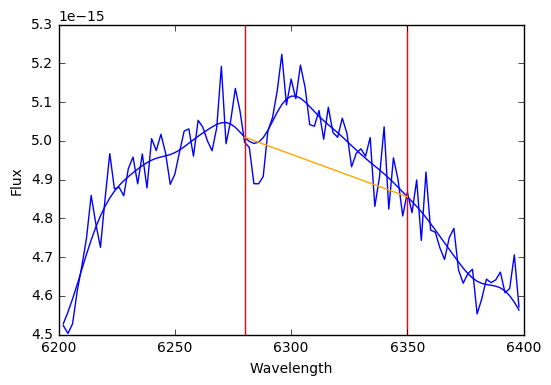

-1.03633146364
-----------------------------------------------------------------------------------------
108 | 2007n | N


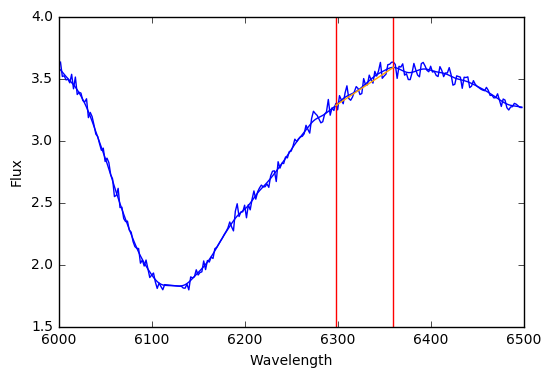

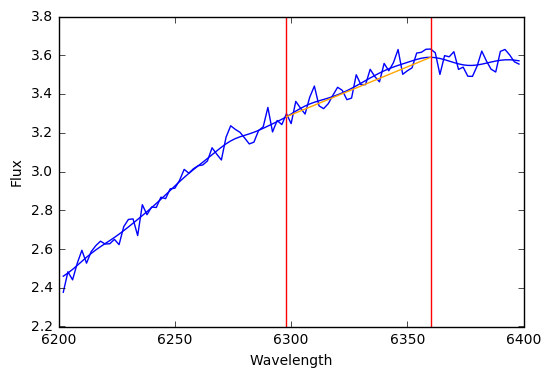

-0.329321239519
-----------------------------------------------------------------------------------------
109 | 2007o | N


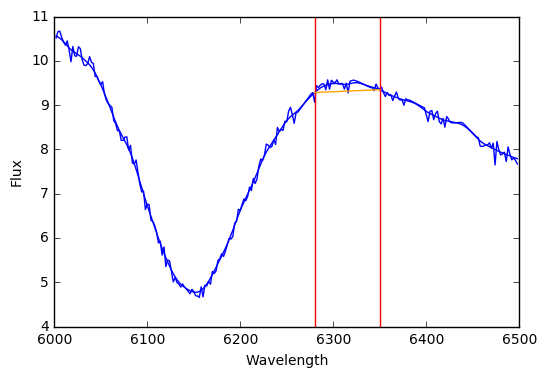

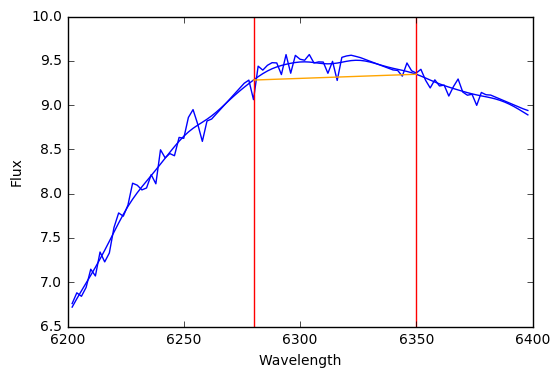

-1.06136734028
-----------------------------------------------------------------------------------------
110 | 2007on | F


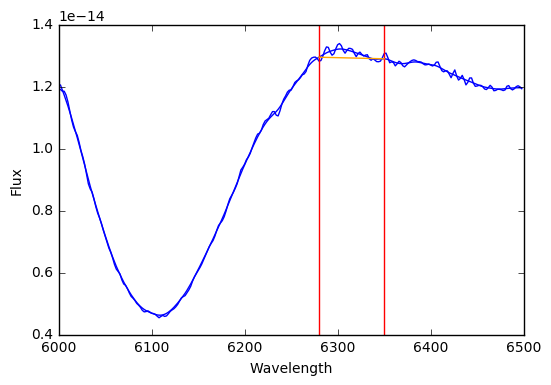

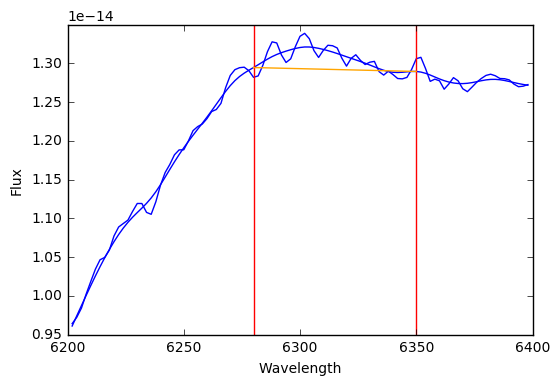

-0.749600098046
-----------------------------------------------------------------------------------------
111 | 2007qe | N


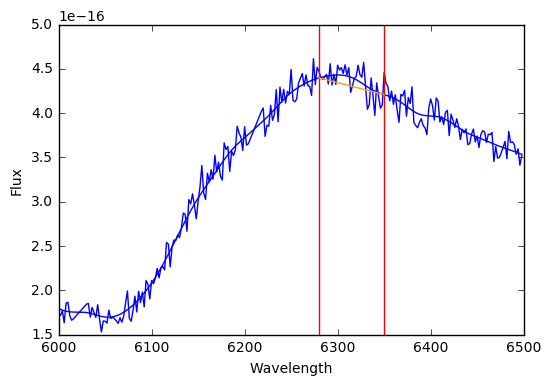

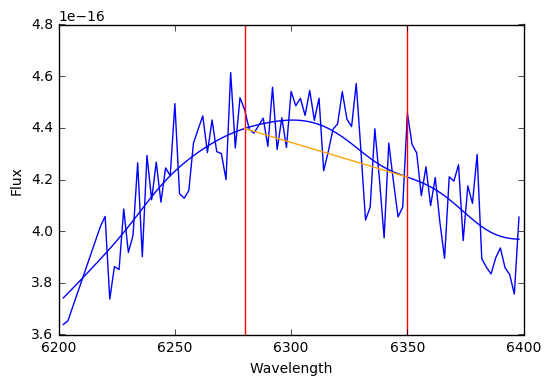

-0.885624804645
-----------------------------------------------------------------------------------------
112 | 2008bf | A


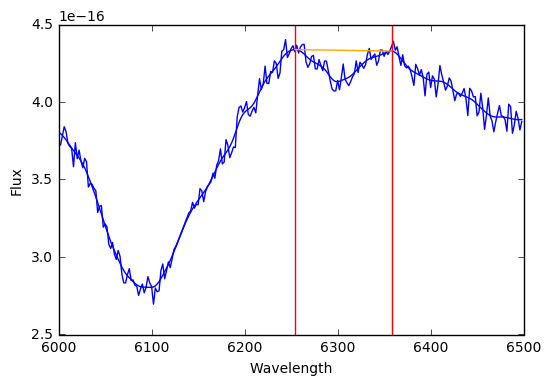

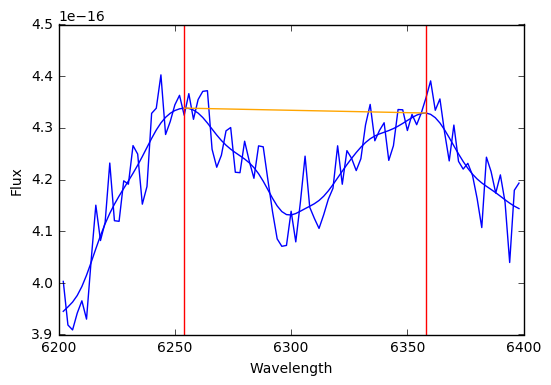

2.22310892892
-----------------------------------------------------------------------------------------
113 | 1996x | F


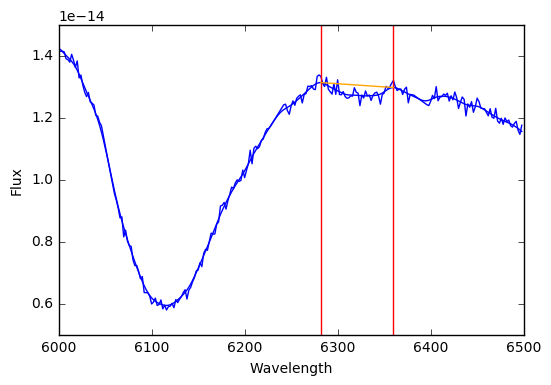

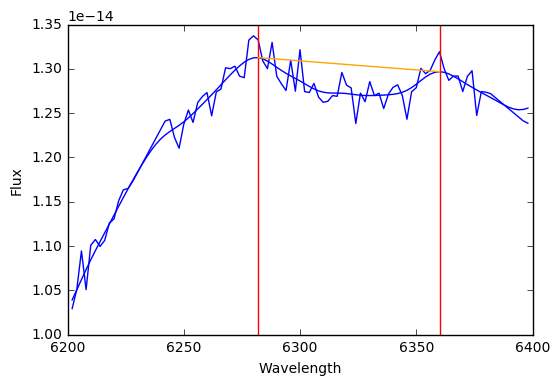

1.35605370927
-----------------------------------------------------------------------------------------
114 | 1998ab | N


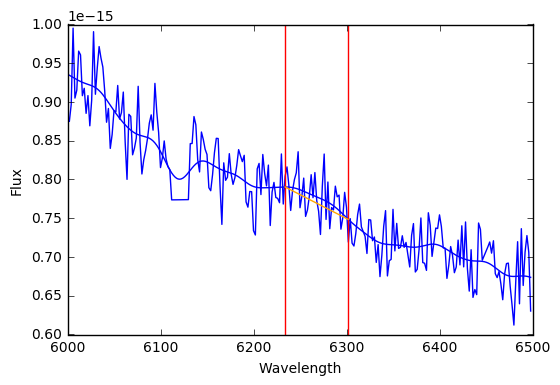

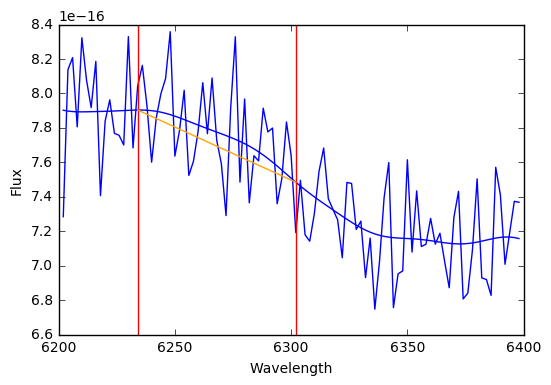

-0.787681857465
-----------------------------------------------------------------------------------------
115 | 1999cc | N


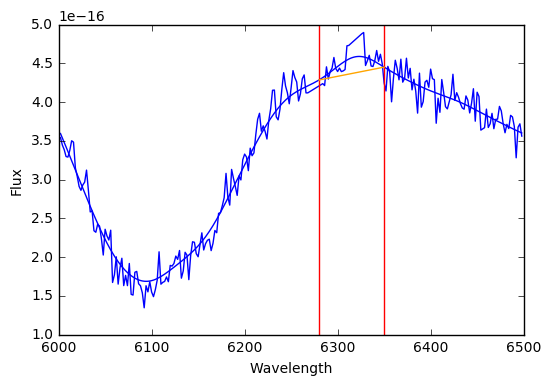

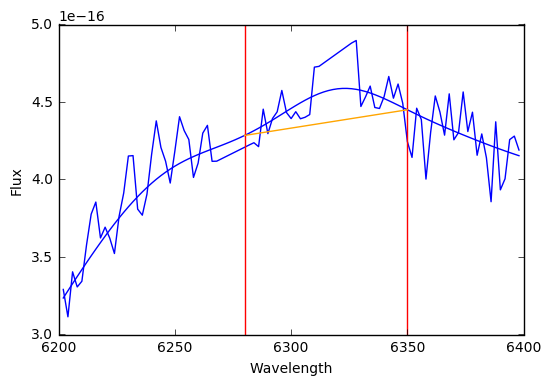

-2.78827627266
-----------------------------------------------------------------------------------------
116 | 1999ej | N


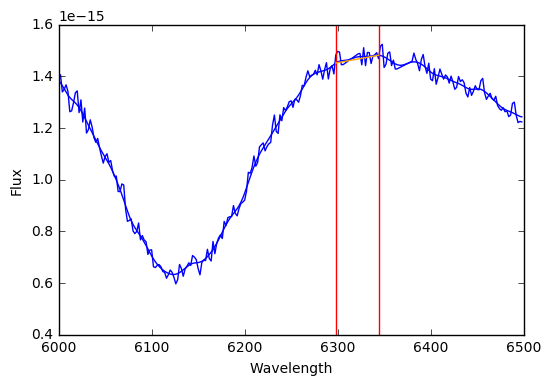

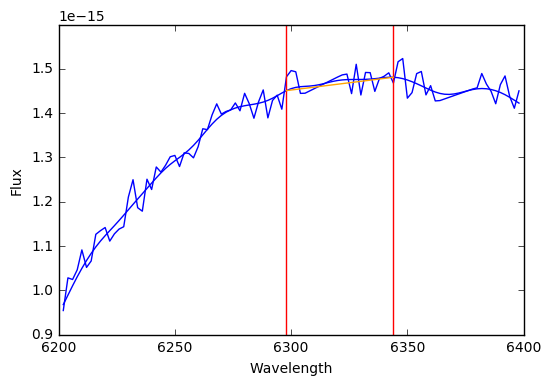

-0.209537359033
-----------------------------------------------------------------------------------------
117 | 1999gp | N


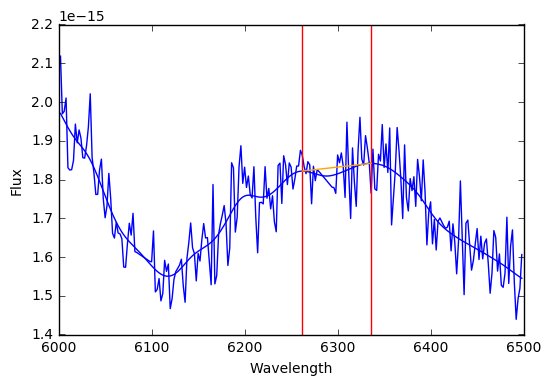

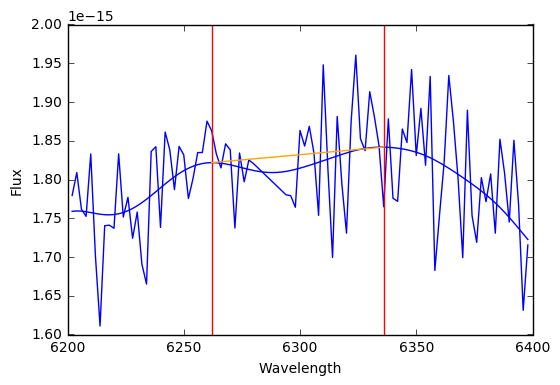

0.32315506932
-----------------------------------------------------------------------------------------
118 | 2003cg | F


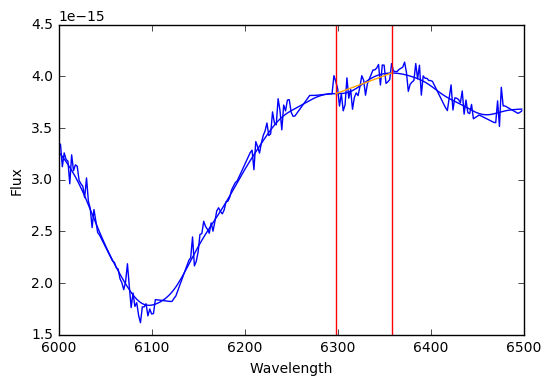

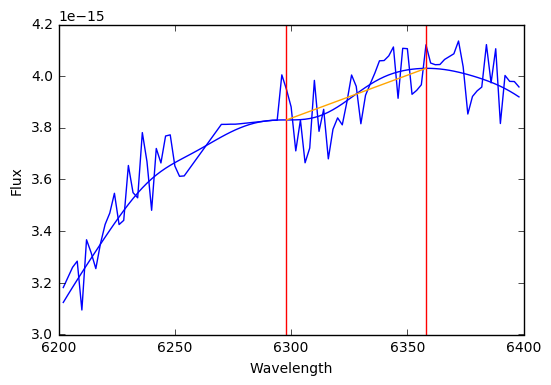

0.227953111866
-----------------------------------------------------------------------------------------
119 | 2007jg | N


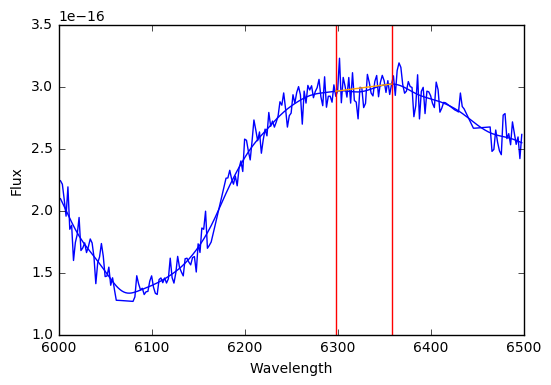

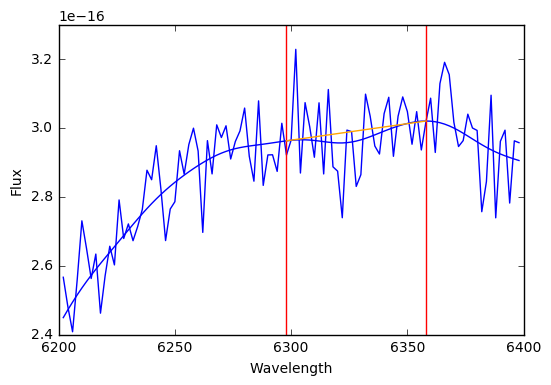

0.217549114022
-----------------------------------------------------------------------------------------
120 | 2006hx | N


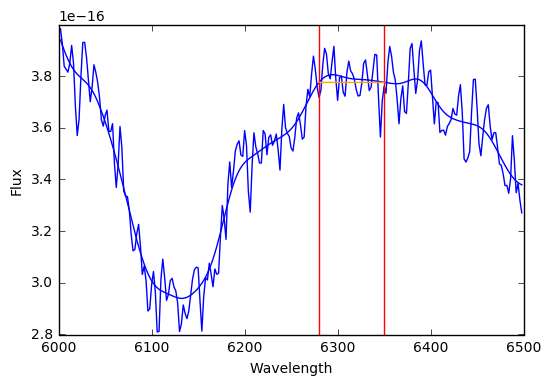

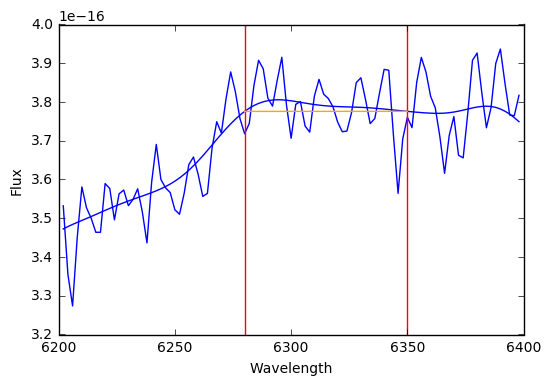

-0.287409482867
-----------------------------------------------------------------------------------------
121 | 2007ai | N


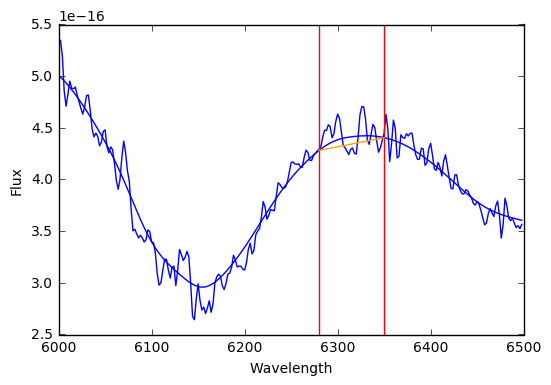

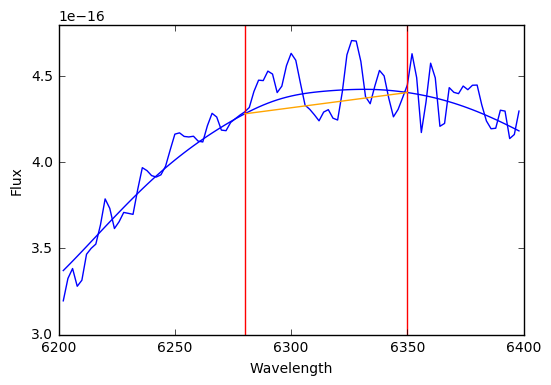

-1.37511014485
-----------------------------------------------------------------------------------------
122 | 2007as | N


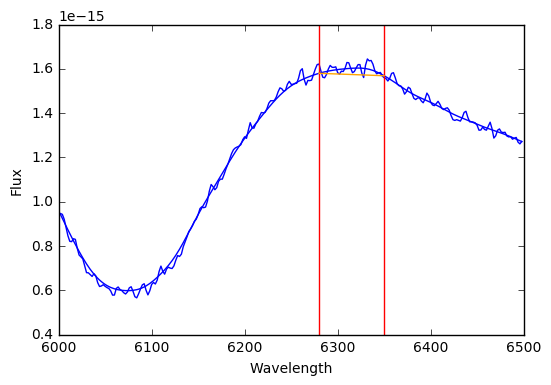

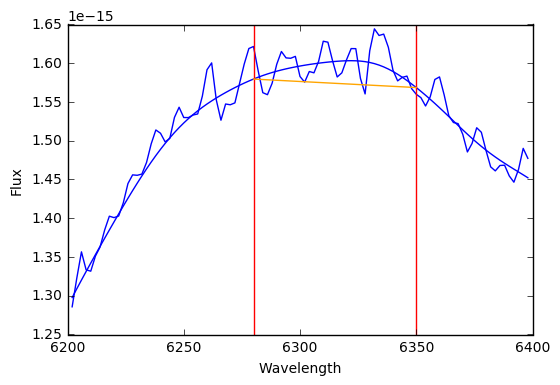

-1.04701714216
-----------------------------------------------------------------------------------------
123 | 2008bq | N


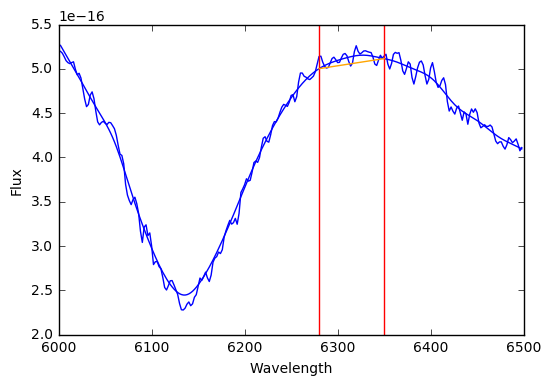

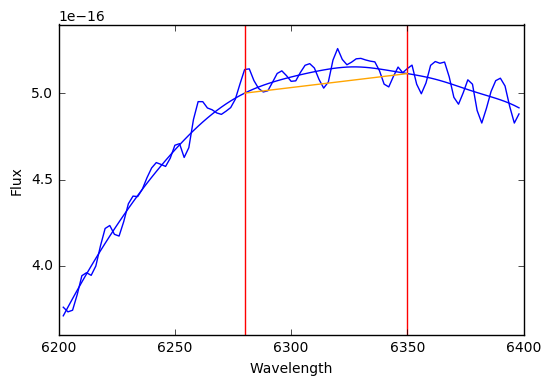

-0.900919557565
-----------------------------------------------------------------------------------------
124 | 2008fp | A


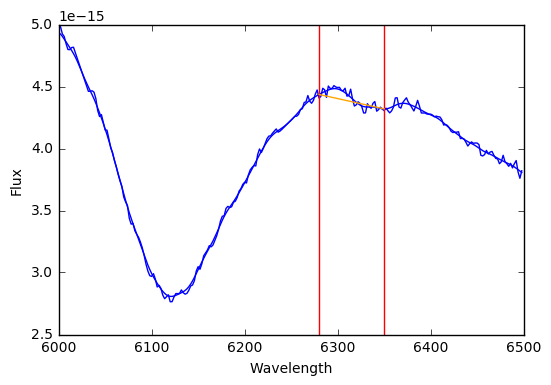

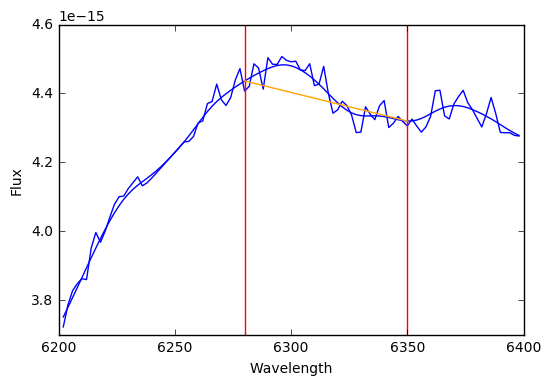

-0.414727708121
-----------------------------------------------------------------------------------------


In [20]:
for i, e in enumerate(New_SN_Array):
    print i, '|', e.name, '|', e.carbon
    print eq_width(e,6200,6300,6400,plot=True)
#     print ew_error(i, 1, plot=True)
    print '-----------------------------------------------------------------------------------------'

# Checking Code

In [ ]:
a=3

print eq_width(New_SN_Array[a],6200,6300,6400, plot=True) 

print ew_error(New_SN_Array[a], 5, plot=True)

In [ ]:
print eq_width(New_SN_Array[a],6200,6300,6400), ew_error(New_SN_Array[a],100)


Make sure range not too small, if too small fix range to 6250, 6350
Look at original plots

In [ ]:
max_1s=[]
max_2s=[]
for i in New_SN_Array:
    if i.carbon=='A':
        max_1s.append(max_wave(i,6200,6300))
        max_2s.append(max_wave(i,6300,6400))

In [ ]:
np.average(max_1s)

In [ ]:
np.average(max_2s)

In [ ]:
6350-6280